# Homework #2: train a CTC speech recognition model

In lecture you have examined the basics of speech recognition and covered the Connectionist Temporal Classification (CTC) model in detail. You are now ready to train your first "adult" speech recognition system!

In seminar 2 you implemented the CTC forward and backward algorithms in order to calculate the CTC loss and study the diffusion of probability in a CTC trellis. Also you implemented a greedy decoder and a prefix beam-search decoder

In this homework you will implement and train a CTC speech recognition model on a subset of the LibriSpeech corpus. This task will involve:

- Creating a dataloader
- Implementing a and training a Neural Network for CTC
  * DNN
  * LSTM
  * BiLSTM
- Comparing the Properties of these models

# Setup - Install package, download files, etc...

In [1]:
# uncomment if needed. If you run the notebook in Colab, all these libraries are pre-installed
# !pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install numpy==1.17.5 matplotlib==3.3.3 tqdm==4.54.0

In [2]:
# !pip install https://github.com/kpu/kenlm/archive/master.zip

In [3]:
%%capture
# !pip install wandb -qqq

In [1]:
#!L
import math
import os
import gc
import shutil
import string
import time
from collections import defaultdict
from typing import List, Tuple, TypeVar, Optional, Callable, Iterable

import arpa
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchaudio.transforms as tt
import wandb
from matplotlib.colors import LogNorm
from torch import optim
from tqdm.notebook import tqdm

In [2]:
import utils as utils   # Change relative path if needed

# Seminar 2 recap: CTC Forward-Backward Algorithm + Soft alignment

## CTC Forward Algorithm

In [3]:
# Helper functions
BLANK_SYMBOL = "_"

class Tokenizer:
    """
    Maps characters to integers and vice versa
    """
    def __init__(self):
        self.char_map = {}
        self.index_map = {}
        for i, ch in enumerate(["'", " "] + list(string.ascii_lowercase) + [BLANK_SYMBOL]):
            self.char_map[ch] = i
            self.index_map[i] = ch
        
    def text_to_indices(self, text: str) -> List[int]:
        return [self.char_map[ch] for ch in text]

    def indices_to_text(self, labels: List[int]) -> str:                                                                                                                                                                                                                                 
        return "".join([self.index_map[i] for i in labels])
    
    def get_symbol_index(self, sym: str) -> int:
        return self.char_map[sym]
    

tokenizer = Tokenizer()

NEG_INF = -float("inf")


def logsumexp(*args) -> float:
    """
    Log-sum-exp trick for log-domain calculations
    See for details: https://en.wikipedia.org/wiki/LogSumExp
    """
    if all(a == NEG_INF for a in args):
        return NEG_INF
    a_max = max(args)
    lsp = math.log(sum(math.exp(a - a_max) for a in args))
    return a_max + lsp


def modify_sequence(sequence: List[int], blank_idx: int) -> List[int]:
    """
    Modifies sequence which with START, END blanks and between each character
    """
    modified_sequence = []
    
    for idx in sequence:
        modified_sequence += [blank_idx, idx]
        
    modified_sequence.append(blank_idx)
    return modified_sequence

In [4]:
#!L

def forward_algorithm(sequence: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    :param sequence: a string converted to an index array by Tokenizer
    :param matrix: A matrix of shape (K, T) with probability distributions over phonemes at each moment of time.
    :return: the result of the forward pass of shape (2 * len(sequence) + 1, T)
    """
    # Turn probs into log-probs
    matrix = np.log(matrix)
    
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    mod_sequence = modify_sequence(sequence, blank)

    # Initialze
    # (2L + 1) x T 
    alphas = np.full([len(mod_sequence), matrix.shape[1]], NEG_INF)

    for t in range(matrix.shape[1]):
        for s in range(len(mod_sequence)):
            # First Step
            ch = mod_sequence[s]
            if t == 0:
                if s != 0 and s != 1:
                    alphas[s][t] = NEG_INF
                else:
                    alphas[s][t] = matrix[ch][t]
                
            # Upper diagonal zeros
            elif s < alphas.shape[0] - 2 * (alphas.shape[1]-t)-1:# CONDITION
                alphas[s][t] = NEG_INF
            else:
                # Need to do this stabily
                if s == 0:
                    alphas[s][t] = alphas[s][t-1] + matrix[ch][t]
                elif s == 1:
                    alphas[s][t] = logsumexp(alphas[s][t-1], alphas[s-1][t-1]) + matrix[ch][t]
                else:
                    if ch == blank or ch == mod_sequence[s-2]:
                        alphas[s][t] = logsumexp(alphas[s][t-1], alphas[s-1][t-1]) + matrix[ch][t]
                    else:
                        alphas[s][t] = logsumexp(alphas[s][t-1], alphas[s-1][t-1], alphas[s-2][t-1]) + matrix[ch][t]
    return alphas

## The CTC Backward Algorithm

In [5]:
def backward_algorithm(sequence: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    :param sequence: a string converted to an index array by Tokenizer
    :param matrix: A matrix of shape (K, T) with probability distributions over phonemes at each moment of time.
    :return: the result of the backward pass of shape (2 * len(sequence) + 1, T)
    """
    matrix = np.log(matrix)
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    mod_sequence = modify_sequence(sequence, blank)
    betas = np.full([len(mod_sequence), matrix.shape[1]], NEG_INF)

    for t in reversed(range(matrix.shape[1])):
        for s in reversed(range(len(mod_sequence))):
            # First Step
            ch = mod_sequence[s]
            if t == matrix.shape[1] - 1:
                if s == betas.shape[0]-1 or s == betas.shape[0]-2:
                    betas[s][t] = 0

            # Lower Diagonal Zeros
            elif s > 2 * t + 1:# CONDITION
                betas[s][t] = NEG_INF
            else:
                if s == len(mod_sequence) - 1:
                    betas[s][t] = betas[s][t+1] + matrix[ch][t]
                elif s == len(mod_sequence) - 2:
                    betas[s][t] = logsumexp(betas[s][t+1], betas[s+1][t+1]) + matrix[ch][t]
                else:
                    if ch == blank or ch == mod_sequence[s + 2]:
                            betas[s][t] = logsumexp(betas[s][t+1], betas[s+1][t+1]) + matrix[ch][t]
                    else:                
                        betas[s][t] = logsumexp(betas[s][t+1], betas[s+1][t+1], betas[s+2][t+1]) + matrix[ch][t]
    return betas

## Soft-Alignment


In [6]:
def soft_alignment(labels_indices: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    Returns the alignment coefficients for the input sequence
    """
    alphas = forward_algorithm(labels_indices, matrix)
    betas = backward_algorithm(labels_indices, matrix)

    # Move from log space back to prob space
    align = np.exp(alphas + betas)

    # Normalize Alignment
    align = align / np.sum(align, axis=0)

    return align

## Greedy Best-Path Decoder


In [7]:
#!L
def greedy_decoder(output: torch.Tensor, labels: List[torch.Tensor], 
                   label_lengths: List[int], collapse_repeated: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    :param output: torch.Tensor of Probs or Log-Probs of shape [batch, time, classes]
    :param labels: list of label indices converted to torch.Tensors of shape (batch, time)
    :param label_lengths: list of label lengths (without padding)
    :param collapse_repeated: whether the repeated characters should be deduplicated
    :return: the result of the decoding and the target sequence
    """
    blank_label = tokenizer.get_symbol_index(BLANK_SYMBOL)

    # Get max classes
    ########################
    arg_maxes = output.argmax(dim=-1)
    ########################

    decodes = []
    targets = []

    # For targets and decodes remove repeats and blanks
    for i, args in enumerate(arg_maxes):
        decode = []
        true_labels = labels[i][:label_lengths[i]].tolist()
        targets.append(tokenizer.indices_to_text(true_labels))

        # Remove repeats, then remove blanks
        for j, index in enumerate(args):
            ########################
            if j != 0:
                if index == args[j-1]:
                    continue
            decode.append(int(index.cpu().detach()))    
            ########################
        ####
        decode = [x for x in decode if x != blank_label]
        ######
        
        decodes.append(tokenizer.indices_to_text(decode))
    return decodes, targets

## Prefix Decoding With LM

In [8]:
LanguageModel = TypeVar("LanguageModel")
# Helper function

class Beam:
    def __init__(self, beam_size: int) -> None:
        self.beam_size = beam_size
        
        fn = lambda : (NEG_INF, NEG_INF)
        
        # Store probs key - prefix, value - p_blank, p_not_blank for ? step
        self.candidates = defaultdict(fn)
        
        # Store sorted by cumulative probability self.candidates
        self.top_candidates_list = [
            (
                tuple(), 
                (0.0, NEG_INF) # log(p_blank) = 0, log(p_not_blank) = -inf
            )
        ]
        
    def get_probs_for_prefix(self, prefix: Tuple[int]) -> Tuple[float, float]:
        p_blank, p_not_blank = self.candidates[prefix]
        return p_blank, p_not_blank
        
    def update_probs_for_prefix(self, prefix: Tuple[int], next_p_blank: float, next_p_not_blank: float) -> None:
        self.candidates[prefix] = (next_p_blank, next_p_not_blank)
        
    def update_top_candidates_list(self) -> None:
        top_candidates = sorted(
            self.candidates.items(), 
            key=lambda x: logsumexp(*x[1]), 
            reverse=True
        )
        self.top_candidates_list = top_candidates[:self.beam_size]
        

def calculate_probability_score_with_lm(lm: LanguageModel, prefix: str) -> float:
    text = tokenizer.indices_to_text(prefix).strip()    # Use upper case for LM and remove the trailing space
    lm_prob = lm.score(text, eos=False)             
    score = lm_prob / np.log10(np.e)    # Convert to natural log, as ARPA LM uses log10   
    return score

In [9]:
#!L

def decode(probs: np.ndarray, beam_size: int = 5, lm: Optional[LanguageModel] = None, 
           prune: float = 1e-5, alpha: float = 0.1, beta: float = 2):
    """
    :param probs: A matrix of shape (T, K) with probability distributions over phonemes at each moment of time.
    :param beam_size: the size of beams
    :lm: arpa language model
    :prune: the minimal probability for a symbol at which it can be added to a prefix
    :alpha: the parameter to de-weight the LM probability
    :beta: the parameter to up-weight the length correction term
    :return: the prefix with the highest sum of probabilites P_blank and P_not_blank
    """
    T, S = probs.shape
    probs = np.log(probs)
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    space = tokenizer.get_symbol_index(" ")
    prune = NEG_INF if prune == 0.0 else np.log(prune)
    
    beam = Beam(beam_size)
    # Итерируемся по оси времени
    for t in range(T):
        next_beam = Beam(beam_size)
        
        # Итерируемся по символам
        for s in range(S):
            p = probs[t, s]
            # Prune the vocab - пропускаем символ, если вероятность оказаться в нем слишком мала на t-м щаге
            if p < prune:   
                continue
            
            # Итерируемся по варинатам, в которые можем пойти из текущего символа
            # Сначала идут наиболее вероятные по сумме log(p_blank + p_not_blank) префиксы
            # (p_blank, p_not_blank) - вероятности на предыдущем t-1 шаге
            for prefix, (p_blank, p_not_blank) in beam.top_candidates_list:
                # Текущий символ - бланк 
                if s == blank:
                    # вероятности на текущем шаге
                    p_b, p_nb = next_beam.get_probs_for_prefix(prefix)
                    next_beam.update_probs_for_prefix(
                        prefix=prefix,
                        next_p_blank=logsumexp(p_b, p_blank + p, p_not_blank + p),
                        next_p_not_blank=p_nb
                    )
                    continue

                end_t = prefix[-1] if prefix else None
                n_prefix = prefix + (s,)
                
                # Повторяющийся символ
                if s == end_t:
                    # Предыдущий символ - бланк
                    p_b, p_nb = next_beam.get_probs_for_prefix(n_prefix)
                    next_beam.update_probs_for_prefix(
                        prefix=n_prefix,
                        next_p_blank=p_b,
                        next_p_not_blank=logsumexp(p_nb, p + p_blank)
                    )
                    # Предудщий символ не бланк
                    p_b, p_nb = next_beam.get_probs_for_prefix(prefix)
                    next_beam.update_probs_for_prefix(
                        prefix=prefix,
                        next_p_blank=p_b,
                        next_p_not_blank=logsumexp(p_nb, p + p_not_blank)
                    )
                elif s == space and end_t is not None and lm is not None:
                    # Символ - пробел и не первый, нужно применить языковую модель
                    p_b, p_nb = next_beam.get_probs_for_prefix(n_prefix)
                    score = calculate_probability_score_with_lm(lm, n_prefix)
                    length = len(tokenizer.indices_to_text(prefix))
                    
                    next_beam.update_probs_for_prefix(
                        prefix=n_prefix,         
                        next_p_blank=p_b,
                        next_p_not_blank=logsumexp(
                            p_nb,
                            p_blank + p + score * alpha + np.log(length) * beta,
                            p_not_blank + p + score * alpha + np.log(length) * beta
                        )  
                    )
                else:
                    p_b, p_nb = next_beam.get_probs_for_prefix(n_prefix)
                    next_beam.update_probs_for_prefix(
                        prefix=n_prefix,
                        next_p_blank=p_b,
                        next_p_not_blank=logsumexp(p_nb, p_blank + p, p_not_blank + p)
                    )

        next_beam.update_top_candidates_list()
        beam = next_beam

    best = beam.top_candidates_list[0]
    return best[0], -logsumexp(*best[1])


def beam_search_decoder(probs: np.ndarray, labels: List[List[int]], label_lengths: List[int], 
                        input_lengths: List[int], lm: LanguageModel, beam_size: int = 5,
                        prune: float = 1e-3, alpha: float = 0.1, beta: float = 0.1):
    probs = probs.cpu().detach().numpy()
    decodes, targets = [], []
    
    for i, prob in enumerate(probs):
        targets.append(tokenizer.indices_to_text(labels[i][:label_lengths[i]].tolist()))
        int_seq, _ = decode(prob[:input_lengths[i]], lm=lm, beam_size=beam_size, prune=prune, alpha=alpha, beta=beta)
        decodes.append(tokenizer.indices_to_text(int_seq))
        
    return decodes, targets

# Homework 2 starts here: CTC Speech Recognition System
You can do this notebook in google collab, or use other GPU sources

### Tasks

- (25 points) Train ASR System, WER criterions: 60-50 -- 9 points, 50-40 -- 15 points, 40-35 -- 20 points, <=35 -- 25 points. + 1 bonus point per 1% WER below 30
- (2 points) Compare performance of DNN, RNN and BiRNN models in terms of WER, training time and other properties
- (3 points) Compare alignments obtained from DNN, RNN and BiRNN models

## Implementing, training and evaluationg your CTC ASR model

### Create a Dataloader

The first step is to create a dataloader to download and load and preprocess LibriSpeech acoustic data. 

The creative options you have at this stage are:

* The sample rate and number of mel-bins.
* Various forms of data agumentation

In [10]:
#!L
# Download LibriSpeech 100hr training and test data

if not os.path.isdir("./data"):
    os.makedirs("./data")

train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url="test-clean", download=True)

In [11]:
#!L
train_audio_transforms = nn.Sequential(
    tt.MelSpectrogram(),
    tt.TimeMasking(time_mask_param=15),
    tt.FrequencyMasking(freq_mask_param=20)
)

test_audio_transforms = nn.Sequential(
    tt.MelSpectrogram()
)

/home/eduard/mambaforge/envs/mix/lib/python3.9/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [12]:
class Collate:
    def __init__(self, data_type = 'test', stride = 2) -> None:
        super(Collate, self).__init__() 

        self.data_type = data_type
        self.stride = stride

    def __call__(self, data: torchaudio.datasets.librispeech.LIBRISPEECH) -> Tuple[List[torch.Tensor], ...]:
        """
        :param data: is a list of tuples of [features, label], where features has dimensions [n_features, length]
        "returns features, lengths, labels: 
              features is a Tensor [batchsize, features, max_length]
              lengths is a Tensor of lengths [batchsize]
              labels is a Tesnor of targets [batchsize]
        """

        spectrograms = []
        labels = []
        input_lengths = []
        label_lengths = []
        for (waveform, _, utterance, _, _, _) in data:
            if self.data_type == 'train':
                spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
            elif self.data_type == 'test':
                spec = test_audio_transforms(waveform).squeeze(0).transpose(0, 1)
            else:
                raise Exception('data_type should be train or valid')
            spectrograms.append(spec)
            label = torch.LongTensor(tokenizer.text_to_indices(utterance.lower()))
            labels.append(label)
            input_lengths.append(spec.shape[0] // self.stride)
            label_lengths.append(len(label))

        spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
        labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

        return spectrograms, labels, input_lengths, label_lengths


### Implement a Neural Network Model

You should try out a few different model types:
- Feed-Forward Model (DNN)
- Recurrent Model (GRU or LSTM)
- Bidirectional Recurrent Model (bi-GRU or bi-LSTM)
- Something different for bonus points

Before any of this models you can use convolutional layers, as shown in the example below

After your experiments you should write a report with comparison of different models in terms of different features, for example: parameters, training speed, resulting quality, spectrogram properties, and data augmentations. Remember, that for full mark you need to achive good WER 

WER criterions: 60-50 -- 9 points, 50-40 -- 15 points, 40-35 -- 20 points, <= 35 -- 25 points

In [13]:
#!L

# Our model classes are just examples, you can change them as you want

# Define model
class CNNLayerNorm(nn.Module):
    """Layer normalization built for CNNs input"""

    def __init__(self, n_feats: int) -> None:
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous()  # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous()  # (batch, channel, feature, time)


class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """

    def __init__(self, in_channels: int, out_channels: int, kernel: int, stride: int, dropout: float, n_feats: int) -> None:
        super(ResidualCNN, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel,
                stride=stride,
                padding=kernel // 2
            ),
            CNNLayerNorm(n_feats),
            nn.ReLU(),
            nn.Dropout(dropout, inplace=False),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=kernel,
                stride=1,
                padding=kernel // 2
            ),
            CNNLayerNorm(n_feats)
        )

        # Residual connection: Adjust dimensions if necessary
        if in_channels != out_channels or stride != 1:
            self.residual_conv = nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0
            )
        else:
            self.residual_conv = nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x.shape = (batch, channel, feature, time)
        residual = self.residual_conv(x)
        x = self.conv_block(x)
        x += residual
        return x


class FeatureExtractor(nn.Module):
    def __init__(self, n_cnn_layers: int, rnn_dim: int,
                 n_feats: int, stride: int = 2, dropout: float = 0.1, channels: int = 32) -> None:
        super(FeatureExtractor, self).__init__()
        
        n_feats //= stride
        
        self.cnn = nn.Conv2d(
            in_channels=1,
            out_channels=channels,
            kernel_size=3,
            stride=stride,
            padding=3//2
        )

        # n residual cnn layers with filter size of 32
        residual_layers = [
            ResidualCNN(
                in_channels=channels,
                out_channels=channels,
                kernel=3,
                stride=1,
                dropout=dropout,
                n_feats=n_feats
            )
            for _ in range(n_cnn_layers)
        ]
        self.rescnn_layers = nn.Sequential(*residual_layers)

        self.fully_connected = nn.Sequential(
            nn.Linear(channels * n_feats, 4 * n_feats),
            nn.ReLU(),
            nn.Dropout(p=dropout, inplace=False),
            nn.Linear(4 * n_feats, rnn_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout, inplace=False),
            nn.Linear(rnn_dim, rnn_dim)
        )
      

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x.shape = (batch, channel, feature, time)
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2)  # (batch, time, feature)
        x = self.fully_connected(x)
        return x


class CTCDNN(nn.Module):

    def __init__(self, n_cnn_layers: int, n_rnn_layers: int, rnn_dim: int, n_class: int, 
                 n_feats: int, stride: int = 2, dropout: float = 0.1) -> None:
        super(CTCDNN, self).__init__()
        
        self.feature_extractor = FeatureExtractor(
            n_cnn_layers,
            rnn_dim,
            n_feats,
            stride,
            dropout
        )
        
        self.intermediate_layers = nn.Sequential(
            nn.Linear(rnn_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout, inplace=False),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(dropout, inplace=False),
            nn.Linear(256, rnn_dim),
        )

        self.classifier = nn.Linear(rnn_dim, n_class)

    def forward(self, x: torch.Tensor, input_lengths: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        x = self.intermediate_layers(x)
        x = self.classifier(x)
        return x

class CTCRNN(nn.Module):

    def __init__(self, n_cnn_layers: int, n_rnn_layers: int, rnn_dim: int, n_class: int, 
                 n_feats: int, stride: int = 2, dropout: float = 0.1) -> None:
        super(CTCRNN, self).__init__()

        self.feature_extractor = FeatureExtractor(
            n_cnn_layers,
            rnn_dim,
            n_feats,
            stride,
            dropout
        )

        self.intermediate_layers = nn.LSTM(
            input_size=rnn_dim,
            hidden_size=rnn_dim,
            num_layers=n_rnn_layers,
            batch_first=True,
            dropout=dropout if n_rnn_layers > 1 else 0,
            bidirectional=False,
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim, rnn_dim),
            nn.ReLU(),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x: torch.Tensor, input_lengths: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        x, _ = self.intermediate_layers(x)
        x = self.classifier(x)
        return x


class CTCBiRNN(nn.Module):

    def __init__(self, n_cnn_layers: int, n_rnn_layers: int, rnn_dim: int, n_class: int, 
                 n_feats: int, stride: int = 2, dropout: float = 0.1) -> None:
        super(CTCBiRNN, self).__init__()
        
        self.feature_extractor = FeatureExtractor(
            n_cnn_layers,
            rnn_dim,
            n_feats,
            stride,
            dropout
        )

        self.intermediate_layers = nn.LSTM(
            input_size=rnn_dim,
            hidden_size=rnn_dim,
            num_layers=n_rnn_layers,
            batch_first=True,
            dropout=dropout if n_rnn_layers > 1 else 0,
            bidirectional=True,
        )

        self.classifier = nn.Sequential(
            nn.Linear(2*rnn_dim, rnn_dim),
            nn.ReLU(),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x: torch.Tensor, input_lengths: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        x, _ = self.intermediate_layers(x)
        x = self.classifier(x)
        return x

### Training and Evaluation Code

In [14]:
#!L

def train(model: nn.Module, device: str, train_loader: data.DataLoader, 
          criterion: nn.Module, optimizer: torch.optim.Optimizer, 
          scheduler: torch.optim.lr_scheduler, epoch: int) -> None:
    model.train()
    data_len = len(train_loader.dataset)
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms, input_lengths)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1)  # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        scheduler.step()
        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                       100. * batch_idx / len(train_loader), loss.item()))
            wandb.log({'loss_train': loss.item()})
            
        del spectrograms, labels
        torch.cuda.empty_cache()


def test(model: nn.Module, device: str, test_loader: data.DataLoader, 
         criterion: nn.Module, epoch: int, decode: str = 'Greedy', lm: LanguageModel = None,
         save_path: str = None, **decoder_kwargs) -> None:
    print('Beginning eval...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        start = time.time()
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            
            matrix = model(spectrograms, input_lengths)  # (batch, time, n_class)
            probs = F.softmax(matrix,dim=2)
            matrix = F.log_softmax(matrix, dim=2)
            matrix = matrix.transpose(0, 1)  # (time, batch, n_class)
                
            if i == 3:
                np.savetxt(f"{save_path}_matrix.txt", probs[0].cpu().numpy())
                np.savetxt(f"{save_path}_labels.txt", labels[0].cpu().numpy())

            loss = criterion(matrix, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)
            
            decoded_preds = []
            if decode == 'Greedy':
                decoded_preds, decoded_targets = greedy_decoder(matrix.transpose(0, 1), labels, label_lengths)
            elif decode == 'BeamSearch':
                decoded_preds, decoded_targets = beam_search_decoder(probs, labels, label_lengths, input_lengths, lm=lm, **decoder_kwargs)
            
            for j in range(len(decoded_preds)):
                test_cer.append(utils.cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(utils.wer(decoded_targets[j], decoded_preds[j]))     
            

    avg_cer = sum(test_cer) / len(test_cer)
    avg_wer = sum(test_wer) / len(test_wer)
    wandb.log({'loss_test': test_loss, 'avg_cer': avg_cer, 'avg_wer': avg_wer})
    print(
        'Epoch: {:d}, Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(epoch, test_loss,
                                                                                                       avg_cer,
                                                                                                       avg_wer))

In [15]:
#!L
torch.manual_seed(7)
if torch.cuda.is_available():
    print('GPU found! 🎉')
    device = 'cuda'
else:
    print('Only CPU found! 💻')
    device = 'cpu'

verbose=False

# Hyperparameters for your model
hparams = {
    "n_cnn_layers": 5,
    "n_rnn_layers": 2,
    "rnn_dim": 128,
    "n_class": 29,
    "n_feats": 128,
    "stride": 2,
    "dropout": 0.2,
    "learning_rate": 1e-3,
    "batch_size":  64,
    "epochs": 20,
}

train_collate_fn = Collate(data_type='train')
test_collate_fn = Collate(data_type='test')

# Define Dataloyour training and test data loaders
kwargs = {'num_workers': 2, 'pin_memory': True} if device == 'cuda' else {}
train_loader = data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True, collate_fn=train_collate_fn, **kwargs)

kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}
test_loader = data.DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False, collate_fn=test_collate_fn, **kwargs)

GPU found! 🎉


We recommend to use "Weights & Biases" for experiment logging. See their [documentation](https://docs.wandb.ai/) for detais.

## Compare different models: DNN, GRU/LSTM, bi-GRU/bi-LSTM (2 points)

Train and discuss differences in the different models. 

Compare performance of DNN, RNN and BiRNN models in terms of:
-  WER / CER 
-  Training time
-  Training stability 
-  Any other properties?

In [17]:
run = wandb.init(
    project="hw2-dlaudio", 
    group="DNN",
    config=hparams,
    reinit=True
)

wandb: Currently logged in as: edyarich (edyarich-noname). Use `wandb login --relogin` to force relogin


In [18]:
# Train a non-recurrent model
ctc_dnn = CTCDNN(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout'])
ctc_dnn.to(device)

print(sum(p.numel() for p in ctc_dnn.parameters() if p.requires_grad))

optimizer = optim.Adam(ctc_dnn.parameters(), hparams['learning_rate'])
criterion = nn.CTCLoss(blank=tokenizer.get_symbol_index(BLANK_SYMBOL), reduction='mean')
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=hparams['learning_rate'],
    epochs=hparams['epochs'],
    steps_per_epoch=len(train_loader),
    div_factor=5,
    final_div_factor=10,
)

for epoch in tqdm(range(1, hparams['epochs'] + 1)):
    train(ctc_dnn, device, train_loader, criterion, optimizer, scheduler, epoch)
    utils.save_checkpoint(ctc_dnn, checkpoint_name=f'ctc_dnn_epoch{epoch}.tar')
    wandb.save(f'ctc_dnn_epoch{epoch}.tar')
    test(ctc_dnn, device, test_loader, criterion, epoch, save_path='dnn')

utils.save_checkpoint(ctc_dnn, checkpoint_name=f'ctc_dnn.tar')

803485


  0%|          | 0/25 [00:00<?, ?it/s]

Train Epoch: 1 [0/28539 (0%)]	Loss: 7.056157
Train Epoch: 1 [6400/28539 (22%)]	Loss: 2.895197
Train Epoch: 1 [12800/28539 (45%)]	Loss: 2.843529
Train Epoch: 1 [19200/28539 (67%)]	Loss: 2.833130
Train Epoch: 1 [25600/28539 (90%)]	Loss: 2.796686
Beginning eval...
Epoch: 1, Test set: Average loss: 2.7641, Average CER: 0.938595 Average WER: 1.0034

Train Epoch: 2 [0/28539 (0%)]	Loss: 2.716621
Train Epoch: 2 [6400/28539 (22%)]	Loss: 2.572820
Train Epoch: 2 [12800/28539 (45%)]	Loss: 2.443446
Train Epoch: 2 [19200/28539 (67%)]	Loss: 2.406635
Train Epoch: 2 [25600/28539 (90%)]	Loss: 2.291911
Beginning eval...
Epoch: 2, Test set: Average loss: 2.0981, Average CER: 0.599382 Average WER: 1.1549

Train Epoch: 3 [0/28539 (0%)]	Loss: 2.242553
Train Epoch: 3 [6400/28539 (22%)]	Loss: 2.199039
Train Epoch: 3 [12800/28539 (45%)]	Loss: 2.146516
Train Epoch: 3 [19200/28539 (67%)]	Loss: 2.140140
Train Epoch: 3 [25600/28539 (90%)]	Loss: 2.095282
Beginning eval...
Epoch: 3, Test set: Average loss: 1.8855, Av

OutOfMemoryError: CUDA out of memory. Tried to allocate 492.00 MiB. GPU 0 has a total capacity of 15.52 GiB of which 485.25 MiB is free. Including non-PyTorch memory, this process has 15.03 GiB memory in use. Of the allocated memory 13.82 GiB is allocated by PyTorch, and 981.11 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [16]:
run = wandb.init(
    project="hw2-dlaudio", 
    group="RNN",
    config=hparams,
    reinit=True
)

wandb: Currently logged in as: edyarich (edyarich-noname). Use `wandb login --relogin` to force relogin


In [17]:
# Train a  recurrent model
ctc_rnn = CTCRNN(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
).to(device)

print(sum(p.numel() for p in ctc_rnn.parameters() if p.requires_grad))

optimizer = optim.Adam(ctc_rnn.parameters(), hparams['learning_rate'])
criterion = nn.CTCLoss(blank=tokenizer.get_symbol_index(BLANK_SYMBOL), reduction='mean')
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=hparams['learning_rate'],
    epochs=hparams['epochs'],
    steps_per_epoch=len(train_loader),
    div_factor=5,
    final_div_factor=10,
)

for epoch in tqdm(range(1, hparams['epochs'] + 1)):
    train(ctc_rnn, device, train_loader, criterion, optimizer, scheduler, epoch)
    utils.save_checkpoint(ctc_rnn, checkpoint_name=f'ctc_rnn_epoch{epoch}.tar')
    wandb.save(f'ctc_rnn_epoch{epoch}.tar')
    test(ctc_rnn, device, test_loader, criterion, epoch, save_path='rnn')

utils.save_checkpoint(ctc_rnn, checkpoint_name=f'ctc_rnn.tar')

952477


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch: 1 [0/28539 (0%)]	Loss: 6.938030
Train Epoch: 1 [6400/28539 (22%)]	Loss: 2.925008
Train Epoch: 1 [12800/28539 (45%)]	Loss: 2.887421
Train Epoch: 1 [19200/28539 (67%)]	Loss: 2.865070
Train Epoch: 1 [25600/28539 (90%)]	Loss: 2.869794
Beginning eval...
Epoch: 1, Test set: Average loss: 2.9233, Average CER: 1.000000 Average WER: 1.0000

Train Epoch: 2 [0/28539 (0%)]	Loss: 2.866946
Train Epoch: 2 [6400/28539 (22%)]	Loss: 2.873680
Train Epoch: 2 [12800/28539 (45%)]	Loss: 2.869228
Train Epoch: 2 [19200/28539 (67%)]	Loss: 2.861016
Train Epoch: 2 [25600/28539 (90%)]	Loss: 2.868498
Beginning eval...
Epoch: 2, Test set: Average loss: 2.9239, Average CER: 1.000000 Average WER: 1.0000

Train Epoch: 3 [0/28539 (0%)]	Loss: 2.875928
Train Epoch: 3 [6400/28539 (22%)]	Loss: 2.862419
Train Epoch: 3 [12800/28539 (45%)]	Loss: 2.856644
Train Epoch: 3 [19200/28539 (67%)]	Loss: 2.863654
Train Epoch: 3 [25600/28539 (90%)]	Loss: 2.867151
Beginning eval...
Epoch: 3, Test set: Average loss: 2.9041, Av

wandb: Network error (ConnectionError), entering retry loop.


Beginning eval...
Epoch: 8, Test set: Average loss: 1.1346, Average CER: 0.345973 Average WER: 0.8258

Train Epoch: 9 [0/28539 (0%)]	Loss: 1.306664
Train Epoch: 9 [6400/28539 (22%)]	Loss: 1.296902
Train Epoch: 9 [12800/28539 (45%)]	Loss: 1.260107
Train Epoch: 9 [19200/28539 (67%)]	Loss: 1.197465
Train Epoch: 9 [25600/28539 (90%)]	Loss: 1.250734
Beginning eval...
Epoch: 9, Test set: Average loss: 1.0647, Average CER: 0.323537 Average WER: 0.7889

Train Epoch: 10 [0/28539 (0%)]	Loss: 1.202258
Train Epoch: 10 [6400/28539 (22%)]	Loss: 1.213936
Train Epoch: 10 [12800/28539 (45%)]	Loss: 1.195592
Train Epoch: 10 [19200/28539 (67%)]	Loss: 1.209187
Train Epoch: 10 [25600/28539 (90%)]	Loss: 1.187844
Beginning eval...
Epoch: 10, Test set: Average loss: 1.0258, Average CER: 0.311675 Average WER: 0.7684

Train Epoch: 11 [0/28539 (0%)]	Loss: 1.137880
Train Epoch: 11 [6400/28539 (22%)]	Loss: 1.143608


wandb: Network error (TransientError), entering retry loop.


Train Epoch: 11 [12800/28539 (45%)]	Loss: 1.135895
Train Epoch: 11 [19200/28539 (67%)]	Loss: 1.134824
Train Epoch: 11 [25600/28539 (90%)]	Loss: 1.108643
Beginning eval...
Epoch: 11, Test set: Average loss: 0.9814, Average CER: 0.301864 Average WER: 0.7463

Train Epoch: 12 [0/28539 (0%)]	Loss: 1.153894
Train Epoch: 12 [6400/28539 (22%)]	Loss: 1.144186
Train Epoch: 12 [12800/28539 (45%)]	Loss: 1.154065
Train Epoch: 12 [19200/28539 (67%)]	Loss: 1.085833
Train Epoch: 12 [25600/28539 (90%)]	Loss: 1.077855
Beginning eval...
Epoch: 12, Test set: Average loss: 0.9590, Average CER: 0.292593 Average WER: 0.7391

Train Epoch: 13 [0/28539 (0%)]	Loss: 1.059352
Train Epoch: 13 [6400/28539 (22%)]	Loss: 1.083694
Train Epoch: 13 [12800/28539 (45%)]	Loss: 1.032115
Train Epoch: 13 [19200/28539 (67%)]	Loss: 1.162339
Train Epoch: 13 [25600/28539 (90%)]	Loss: 1.045726
Beginning eval...
Epoch: 13, Test set: Average loss: 0.9358, Average CER: 0.287488 Average WER: 0.7213

Train Epoch: 14 [0/28539 (0%)]	Loss: 

In [52]:
run.finish()
run = wandb.init(
    project="hw2-dlaudio", 
    group="BiRNN",
    config=hparams,
    reinit=True
)

wandb: Currently logged in as: edyarich (edyarich-noname). Use `wandb login --relogin` to force relogin


In [17]:
# Train a  recurrent model
hparams = {
    "n_cnn_layers": 4,
    "n_rnn_layers": 2,
    "rnn_dim": 128,
    "n_class": 29,
    "n_feats": 128,
    "stride": 2,
    "dropout": 0.2,
    "learning_rate": 1e-3,
    "batch_size":  64,
    "epochs": 50,
}

ctc_birnn = CTCBiRNN(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
).to(device)

optimizer = optim.Adam(ctc_birnn.parameters(), hparams['learning_rate'])
criterion = nn.CTCLoss(blank=tokenizer.get_symbol_index(BLANK_SYMBOL), reduction='mean')
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=hparams['learning_rate'],
    epochs=hparams['epochs'],
    steps_per_epoch=len(train_loader),
    div_factor=5,
    final_div_factor=10,
)

for epoch in tqdm(range(1, hparams['epochs'] + 1)):
    train(ctc_birnn, device, train_loader, criterion, optimizer, scheduler, epoch)
    utils.save_checkpoint(ctc_birnn, checkpoint_name=f'ctc_birnn_epoch{epoch}.tar')
    wandb.save(f'ctc_birnn_epoch{epoch}.tar')
    test(ctc_birnn, device, test_loader, criterion, epoch, save_path='birnn')

utils.save_checkpoint(ctc_birnn, checkpoint_name=f'ctc_birnn.tar')
torch.save(optimizer.state_dict(), 'adam-birnn.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch: 1 [0/28539 (0%)]	Loss: 6.911115
Train Epoch: 1 [6400/28539 (22%)]	Loss: 2.882538
Train Epoch: 1 [12800/28539 (45%)]	Loss: 2.857287
Train Epoch: 1 [19200/28539 (67%)]	Loss: 2.867389
Train Epoch: 1 [25600/28539 (90%)]	Loss: 2.873442
Beginning eval...
Epoch: 1, Test set: Average loss: 2.9209, Average CER: 1.000000 Average WER: 1.0000

Train Epoch: 2 [0/28539 (0%)]	Loss: 2.861571
Train Epoch: 2 [6400/28539 (22%)]	Loss: 2.889218
Train Epoch: 2 [12800/28539 (45%)]	Loss: 2.877035
Train Epoch: 2 [19200/28539 (67%)]	Loss: 2.883270
Train Epoch: 2 [25600/28539 (90%)]	Loss: 2.865423
Beginning eval...
Epoch: 2, Test set: Average loss: 2.9203, Average CER: 1.000000 Average WER: 1.0000

Train Epoch: 3 [0/28539 (0%)]	Loss: 2.854401
Train Epoch: 3 [6400/28539 (22%)]	Loss: 2.867717
Train Epoch: 3 [12800/28539 (45%)]	Loss: 2.850611
Train Epoch: 3 [19200/28539 (67%)]	Loss: 2.853576
Train Epoch: 3 [25600/28539 (90%)]	Loss: 2.836590
Beginning eval...
Epoch: 3, Test set: Average loss: 2.8186, Av

Train Epoch: 24 [19200/28539 (67%)]	Loss: 0.689353
Train Epoch: 24 [25600/28539 (90%)]	Loss: 0.676663
Beginning eval...
Epoch: 24, Test set: Average loss: 0.5897, Average CER: 0.174970 Average WER: 0.4957

Train Epoch: 25 [0/28539 (0%)]	Loss: 0.654414
Train Epoch: 25 [6400/28539 (22%)]	Loss: 0.648897
Train Epoch: 25 [12800/28539 (45%)]	Loss: 0.649237
Train Epoch: 25 [19200/28539 (67%)]	Loss: 0.663795
Train Epoch: 25 [25600/28539 (90%)]	Loss: 0.639598
Beginning eval...
Epoch: 25, Test set: Average loss: 0.5827, Average CER: 0.174297 Average WER: 0.4883

Train Epoch: 26 [0/28539 (0%)]	Loss: 0.666856
Train Epoch: 26 [6400/28539 (22%)]	Loss: 0.577439
Train Epoch: 26 [12800/28539 (45%)]	Loss: 0.611074
Train Epoch: 26 [19200/28539 (67%)]	Loss: 0.701186
Train Epoch: 26 [25600/28539 (90%)]	Loss: 0.626068
Beginning eval...
Epoch: 26, Test set: Average loss: 0.5772, Average CER: 0.170219 Average WER: 0.4834

Train Epoch: 27 [0/28539 (0%)]	Loss: 0.603004
Train Epoch: 27 [6400/28539 (22%)]	Loss: 0

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)
wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


Train Epoch: 43 [19200/28539 (67%)]	Loss: 0.511988
Train Epoch: 43 [25600/28539 (90%)]	Loss: 0.538767
Beginning eval...
Epoch: 43, Test set: Average loss: 0.4899, Average CER: 0.143723 Average WER: 0.4144

Train Epoch: 44 [0/28539 (0%)]	Loss: 0.534611
Train Epoch: 44 [6400/28539 (22%)]	Loss: 0.561183
Train Epoch: 44 [12800/28539 (45%)]	Loss: 0.486399
Train Epoch: 44 [19200/28539 (67%)]	Loss: 0.477225
Train Epoch: 44 [25600/28539 (90%)]	Loss: 0.499843
Beginning eval...
Epoch: 44, Test set: Average loss: 0.4877, Average CER: 0.143003 Average WER: 0.4132

Train Epoch: 45 [0/28539 (0%)]	Loss: 0.510399
Train Epoch: 45 [6400/28539 (22%)]	Loss: 0.503482
Train Epoch: 45 [12800/28539 (45%)]	Loss: 0.526257
Train Epoch: 45 [19200/28539 (67%)]	Loss: 0.477482
Train Epoch: 45 [25600/28539 (90%)]	Loss: 0.478423
Beginning eval...
Epoch: 45, Test set: Average loss: 0.4874, Average CER: 0.142784 Average WER: 0.4133

Train Epoch: 46 [0/28539 (0%)]	Loss: 0.461296
Train Epoch: 46 [6400/28539 (22%)]	Loss: 0

Evaluate CTC-BiRNN using beam-search

In [18]:
test(ctc_birnn, device, test_loader, criterion, epoch, decode='BeamSearch', save_path='birnn-beam')

Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.137755 Average WER: 0.4013



Evaluate CTC-BiRNN using beam-search + Language Model (4-gram arpa from [here](http://openslr.trmal.net/resources/11/))

In [19]:
import kenlm


lang_model = kenlm.LanguageModel('4-gram.arpa')

Loading the LM will be faster if you build a binary file.
Reading /home/eduard/dep-tasks/audio-dl/hw2/4-gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


In [20]:
for alpha in tqdm([0.1, 0.2, 0.3, 1, 3, 10]):
    print(f"{alpha = }")
    test(ctc_birnn, device, test_loader, criterion, epoch, decode='BeamSearch',
         save_path=f'birnn-beam-with-lm-alpha-{alpha}', lm=lang_model, alpha=alpha)

  0%|          | 0/6 [00:00<?, ?it/s]

alpha = 0.1
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.145288 Average WER: 0.4355

alpha = 0.2
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.164505 Average WER: 0.5419

alpha = 0.3
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.185666 Average WER: 0.6537

alpha = 1
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.259771 Average WER: 0.9567

alpha = 3
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.270331 Average WER: 0.9789

alpha = 10
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.270331 Average WER: 0.9789



In [21]:
for alpha in tqdm([-0.1, 0, 0.1]):
    for beta in tqdm([-1, -0.1, 0, 0.1, 1, 3, 10]):
        print(f"{alpha = }, {beta = }")
        test(ctc_birnn, device, test_loader, criterion, epoch, decode='BeamSearch',
             save_path=f'birnn-beam-with-lm-alpha-{alpha}', lm=lang_model, alpha=alpha,
             beta=beta)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

alpha = -0.1, beta = -1
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.147377 Average WER: 0.4433

alpha = -0.1, beta = -0.1
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.141882 Average WER: 0.4502

alpha = -0.1, beta = 0
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.144016 Average WER: 0.4697

alpha = -0.1, beta = 0.1
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.146627 Average WER: 0.4940

alpha = -0.1, beta = 1
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.193295 Average WER: 0.8573

alpha = -0.1, beta = 3
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.256361 Average WER: 1.2375

alpha = -0.1, beta = 10
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.285318 Average WER: 1.3468



  0%|          | 0/7 [00:00<?, ?it/s]

alpha = 0, beta = -1
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.173389 Average WER: 0.5855

alpha = 0, beta = -0.1
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.138491 Average WER: 0.4017

alpha = 0, beta = 0
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.137755 Average WER: 0.4013

alpha = 0, beta = 0.1
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.137537 Average WER: 0.4047

alpha = 0, beta = 1
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.156269 Average WER: 0.5759

alpha = 0, beta = 3
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.249007 Average WER: 1.2024

alpha = 0, beta = 10
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.284820 Average WER: 1.3455



  0%|          | 0/7 [00:00<?, ?it/s]

alpha = 0.1, beta = -1
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.202065 Average WER: 0.7254

alpha = 0.1, beta = -0.1
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.151888 Average WER: 0.4730

alpha = 0.1, beta = 0
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.148265 Average WER: 0.4521

alpha = 0.1, beta = 0.1
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.145288 Average WER: 0.4355

alpha = 0.1, beta = 1
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.140459 Average WER: 0.4371

alpha = 0.1, beta = 3
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.234720 Average WER: 1.1317

alpha = 0.1, beta = 10
Beginning eval...
Epoch: 50, Test set: Average loss: 0.4835, Average CER: 0.284432 Average WER: 1.3441



In [98]:
for alpha in tqdm([-0.1, 0, 0.1]):
    for beta in tqdm([-1, -0.1, 0, 0.1, 1, 3, 10]):
        print(f"{alpha = }, {beta = }")
        test(ctc_birnn, device, test_loader, criterion, epoch, decode='BeamSearch',
             save_path=f'birnn-beam-with-lm-alpha-{alpha}', lm=lang_model, alpha=alpha,
             beta=beta)
        
del lang_model
gc.collect()
torch.cuda.empty_cache()

alpha = -0.1, beta = -1
Beginning eval...
Epoch: 20, Test set: Average loss: 0.9058, Average CER: 0.292666 Average WER: 0.7483

alpha = -0.1, beta = -0.1
Beginning eval...
Epoch: 20, Test set: Average loss: 0.9058, Average CER: 0.278191 Average WER: 0.8553

alpha = -0.1, beta = 0
Beginning eval...
Epoch: 20, Test set: Average loss: 0.9058, Average CER: 0.284927 Average WER: 0.9178

alpha = -0.1, beta = 0.1
Beginning eval...
Epoch: 20, Test set: Average loss: 0.9058, Average CER: 0.292936 Average WER: 0.9892

alpha = -0.1, beta = 1
Beginning eval...
Epoch: 20, Test set: Average loss: 0.9058, Average CER: 0.412978 Average WER: 1.8830

alpha = -0.1, beta = 3
Beginning eval...
Epoch: 20, Test set: Average loss: 0.9058, Average CER: 0.546906 Average WER: 2.6707

alpha = -0.1, beta = 10
Beginning eval...
Epoch: 20, Test set: Average loss: 0.9058, Average CER: 0.598118 Average WER: 2.8708

alpha = 0, beta = -1
Beginning eval...
Epoch: 20, Test set: Average loss: 0.9058, Average CER: 0.336787 

**Summary:**

1. It's better not to use language model: it increases WER
2. {(0, 0), (0, -0.1)} -- optimal alpha-beta pairs, so it's better not to add extra regularizers

### Conclusion

*Примечание*: Конфигурации моделей слегка отличаются числом cnn слоёв в модели: у BiRNN их 4, а у остальных моделей -- 5. Это связано с ограничением по видеопамяти.

Все метрики приведены для моделей, обученных за 20 эпох

| Модель | Число параметров | Время обучения | CER (на 20 эпохах) | WER (на 20 эпохах) | Использование временнОго контекста |
|--------|------------------|----------------|---------------------|---------------------|------------------------------------|
| DNN    | 803к            | 2 часа            | 0.4                 | 0.97               | -                                  |
| RNN    | 952к            | 2.5 часа      | 0.26                   | 0.69                  | +                                  |
| BiRNN  | 1345к           | 2.5 часа       | 0.19                | 0.54               | +                                 |


Стабильность обучения (по loss-у и CER) у всех моделей присутствует.  
Однако с точки зрения WER, только у BiRNN она монотонно убывала в процессе обучения, в то время как у остальных моделей эта метрика вначале возрастала, а затем убывала, причём немонотонно.

## Compare alignments (3 points)

In this section you should compare alignments obtained from different models (DNN / RNN / BiRNN). For example, you can show:

- Examples of alignments and their analysis. 
- Differencies in the properties of alignment distributions over the dataset. 
- Dynamic of alignments during training (from checkpoints). 
- Connection between alignments and model loss. 
- Which models use the most blanks and why?

/tmp/ipykernel_5475/2972682328.py:6: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  dnn_labels = np.loadtxt('dnn_labels.txt', dtype=np.int32)
/tmp/ipykernel_5475/2972682328.py:8: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all

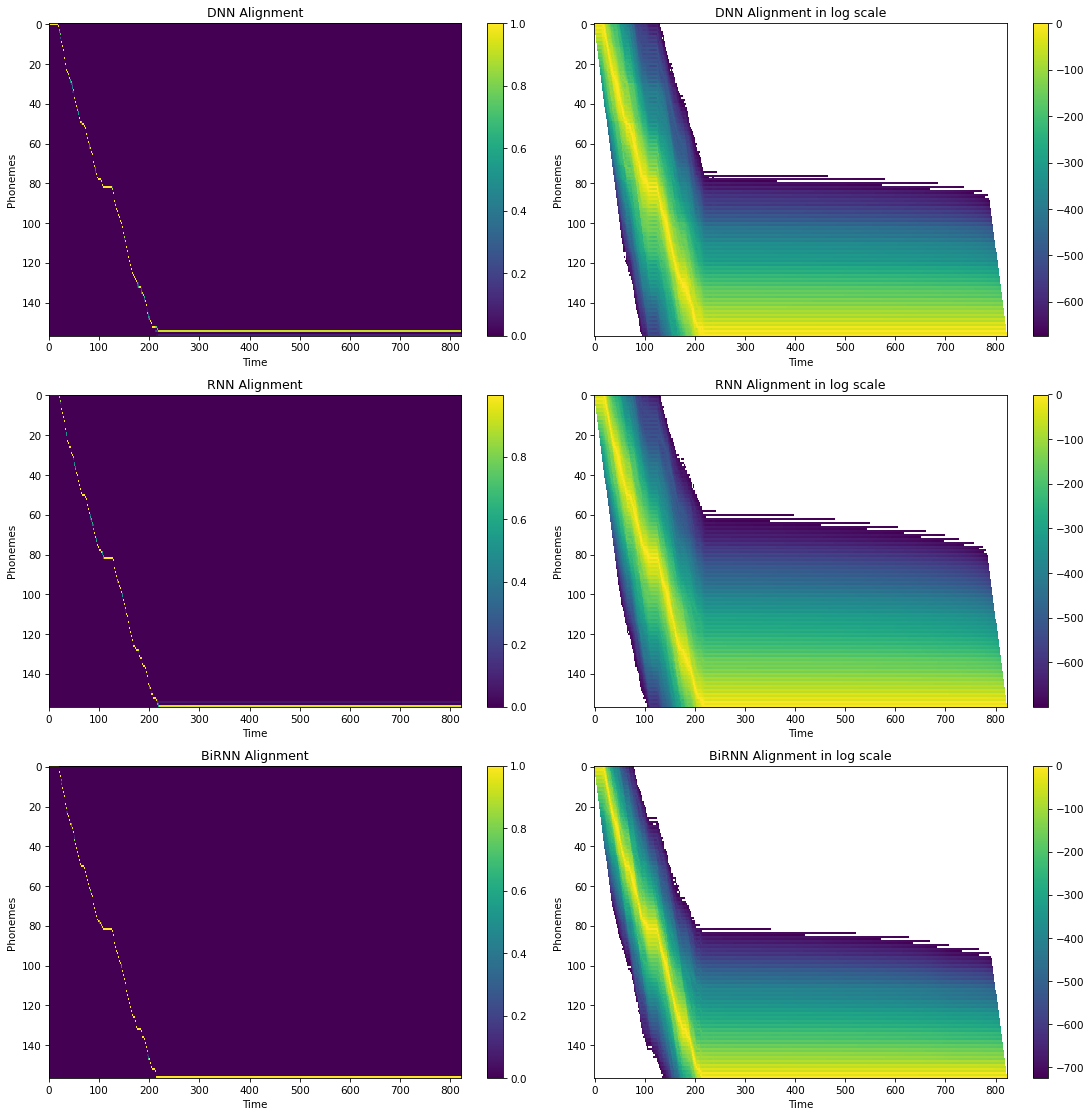

In [42]:
# Some code to get you started.
dnn_matrix = np.loadtxt('dnn_matrix.txt').T
rnn_matrix = np.loadtxt('rnn_matrix.txt').T
birnn_matrix = np.loadtxt('birnn_matrix.txt').T

dnn_labels = np.loadtxt('dnn_labels.txt', dtype=np.int32)
dnn_labels = dnn_labels[dnn_labels != 0]
rnn_labels = np.loadtxt('rnn_labels.txt', dtype=np.int32)
rnn_labels = rnn_labels[rnn_labels != 0]
birnn_labels = np.loadtxt('birnn_labels.txt', dtype=np.int32)
birnn_labels = birnn_labels[birnn_labels != 0]

dnn_align = soft_alignment(dnn_labels, dnn_matrix)
rnn_align = soft_alignment(rnn_labels, rnn_matrix)
birnn_align = soft_alignment(birnn_labels, birnn_matrix)

f, ax = plt.subplots(3, 2, dpi=75, figsize=(15, 15))


im = ax[0,0].imshow(dnn_align, aspect='auto', interpolation='nearest')
ax[0,0].set_title("DNN Alignment")
ax[0,0].set_ylabel("Phonemes")
ax[0,0].set_xlabel("Time")
f.colorbar(im, ax=ax[0,0])

im = ax[0,1].imshow(np.log(dnn_align), aspect='auto', interpolation='nearest')
ax[0,1].set_title("DNN Alignment in log scale")
ax[0,1].set_ylabel("Phonemes")
ax[0,1].set_xlabel("Time")
f.colorbar(im, ax=ax[0,1])

im = ax[1,0].imshow(rnn_align, aspect='auto', interpolation='nearest')
ax[1,0].set_title("RNN Alignment")
ax[1,0].set_ylabel("Phonemes")
ax[1,0].set_xlabel("Time")
f.colorbar(im, ax=ax[1,0])

im = ax[1,1].imshow(np.log(rnn_align), aspect='auto', interpolation='nearest')
ax[1,1].set_title("RNN Alignment in log scale")
ax[1,1].set_ylabel("Phonemes")
ax[1,1].set_xlabel("Time")
f.colorbar(im, ax=ax[1,1])

im = ax[2,0].imshow(birnn_align, aspect='auto', interpolation='nearest')
ax[2,0].set_title("BiRNN Alignment")
ax[2,0].set_ylabel("Phonemes")
ax[2,0].set_xlabel("Time")
f.colorbar(im, ax=ax[2,0])

im = ax[2,1].imshow(np.log(birnn_align), aspect='auto', interpolation='nearest')
ax[2,1].set_title("BiRNN Alignment in log scale")
ax[2,1].set_ylabel("Phonemes")
ax[2,1].set_xlabel("Time")
f.colorbar(im, ax=ax[2,1])

plt.tight_layout()

### Alignment dynamics, connection with model loss

Convert the code above into a function

In [17]:
def plot_alignments(dnn_matrix, rnn_matrix, birnn_matrix, dnn_labels, rnn_labels, birnn_labels):
    dnn_labels = dnn_labels[dnn_labels != 0]
    rnn_labels = rnn_labels[rnn_labels != 0]
    birnn_labels = birnn_labels[birnn_labels != 0]

    dnn_align = soft_alignment(dnn_labels, dnn_matrix)
    rnn_align = soft_alignment(rnn_labels, rnn_matrix)
    birnn_align = soft_alignment(birnn_labels, birnn_matrix)

    f, ax = plt.subplots(3, 2, dpi=75, figsize=(15, 15))

    im = ax[0,0].imshow(dnn_align, aspect='auto', interpolation='nearest')
    ax[0,0].set_title("DNN Alignment")
    ax[0,0].set_ylabel("Phonemes")
    ax[0,0].set_xlabel("Time")
    f.colorbar(im, ax=ax[0,0])

    im = ax[0,1].imshow(np.log(dnn_align), aspect='auto', interpolation='nearest')
    ax[0,1].set_title("DNN Alignment in log scale")
    ax[0,1].set_ylabel("Phonemes")
    ax[0,1].set_xlabel("Time")
    f.colorbar(im, ax=ax[0,1])

    im = ax[1,0].imshow(rnn_align, aspect='auto', interpolation='nearest')
    ax[1,0].set_title("RNN Alignment")
    ax[1,0].set_ylabel("Phonemes")
    ax[1,0].set_xlabel("Time")
    f.colorbar(im, ax=ax[1,0])

    im = ax[1,1].imshow(np.log(rnn_align), aspect='auto', interpolation='nearest')
    ax[1,1].set_title("RNN Alignment in log scale")
    ax[1,1].set_ylabel("Phonemes")
    ax[1,1].set_xlabel("Time")
    f.colorbar(im, ax=ax[1,1])

    im = ax[2,0].imshow(birnn_align, aspect='auto', interpolation='nearest')
    ax[2,0].set_title("BiRNN Alignment")
    ax[2,0].set_ylabel("Phonemes")
    ax[2,0].set_xlabel("Time")
    f.colorbar(im, ax=ax[2,0])

    im = ax[2,1].imshow(np.log(birnn_align), aspect='auto', interpolation='nearest')
    ax[2,1].set_title("BiRNN Alignment in log scale")
    ax[2,1].set_ylabel("Phonemes")
    ax[2,1].set_xlabel("Time")
    f.colorbar(im, ax=ax[2,1])

    plt.tight_layout()
    

def plot_single_alignment(prob_matrix, labels, loss_val):
    labels = labels[labels != 0]
    align = soft_alignment(labels, prob_matrix)
    
    f, ax = plt.subplots(1, 2, dpi=75, figsize=(15, 6))

    im = ax[0].imshow(align, aspect='auto', interpolation='nearest')
    ax[0].set_title(f"Alignment, {loss_val = :.3f}")
    ax[0].set_ylabel("Phonemes")
    ax[0].set_xlabel("Time")
    f.colorbar(im, ax=ax[0])

    im = ax[1].imshow(np.log(align), aspect='auto', interpolation='nearest')
    ax[1].set_title(f"Alignment in log scale, {loss_val = :.3f}")
    ax[1].set_ylabel("Phonemes")
    ax[1].set_xlabel("Time")
    f.colorbar(im, ax=ax[1])
    
    plt.tight_layout()
    

def calc_prob_matrix_and_loss(model, test_loader, device, batch_id: int = 3, sample_id: int = 0):
    assert batch_id < len(test_loader)
    assert sample_id < 64
    
    model.eval()
    criterion = nn.CTCLoss(
        blank=tokenizer.get_symbol_index(BLANK_SYMBOL),
        reduction='mean',
        zero_infinity=True
    )
    
    for i, _data in enumerate(test_loader):
        if i < batch_id:
            continue
        elif i > batch_id:
            break
        
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)
        
        with torch.no_grad():
            matrix = model(spectrograms, input_lengths)
            probs = F.softmax(matrix,dim=2)
            matrix = F.log_softmax(matrix, dim=2)
            matrix = matrix.transpose(0, 1)
            
            loss = criterion(
                matrix[:,sample_id].unsqueeze(1),
                labels[sample_id].unsqueeze(0),
                input_lengths[sample_id:sample_id+1],
                label_lengths[sample_id:sample_id+1]
            )
            
        return probs[sample_id].cpu().numpy(), labels[sample_id].cpu().numpy(), loss.cpu().numpy()

Динамика лосса и выравниваний

Model: ctc_dnn
Epoch 1


/tmp/ipykernel_24917/3920012469.py:63: RuntimeWarning: divide by zero encountered in log
  im = ax[1].imshow(np.log(align), aspect='auto', interpolation='nearest')


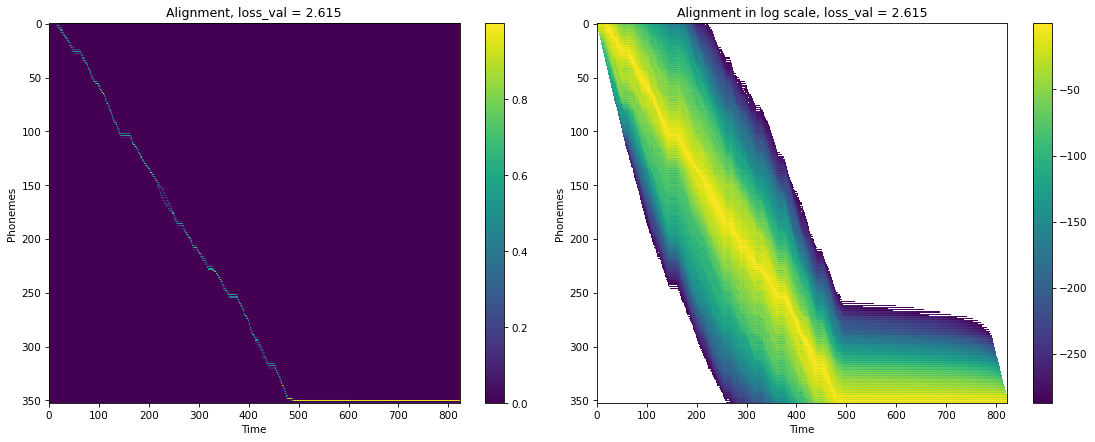

Epoch 4


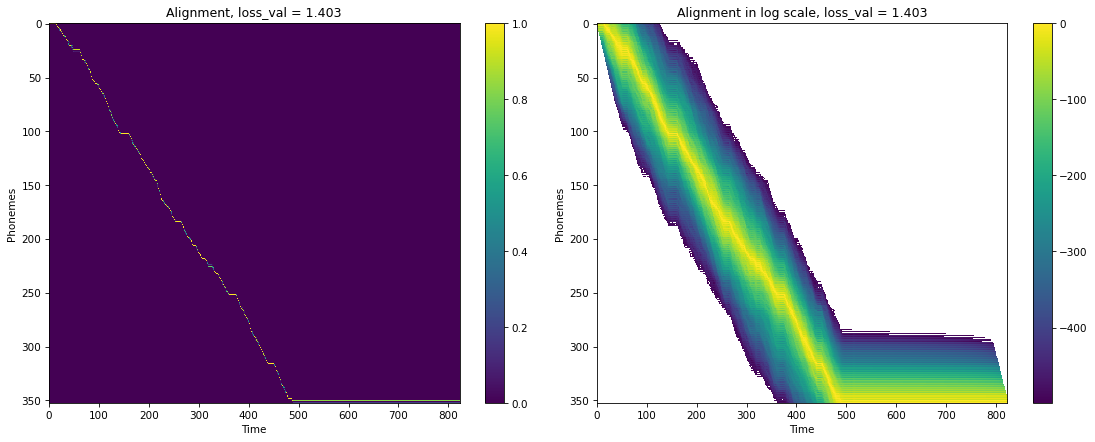

Epoch 7


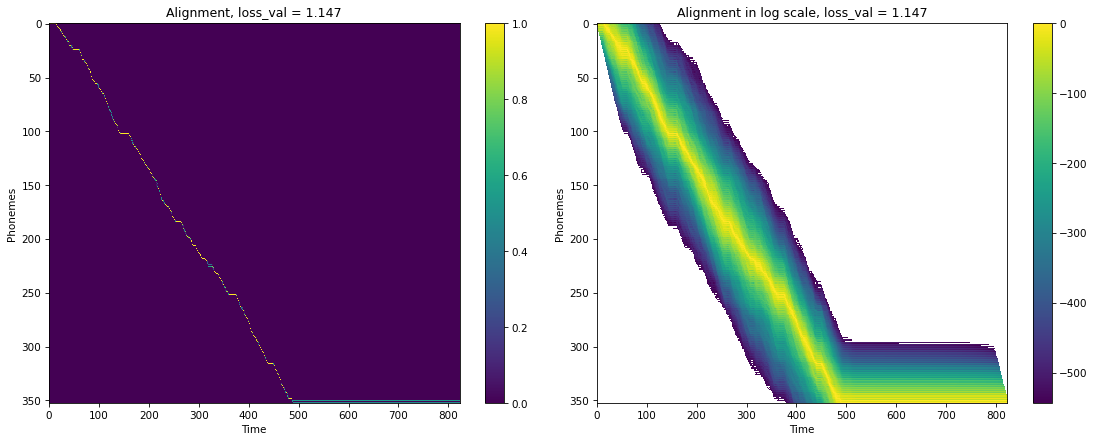

Epoch 10


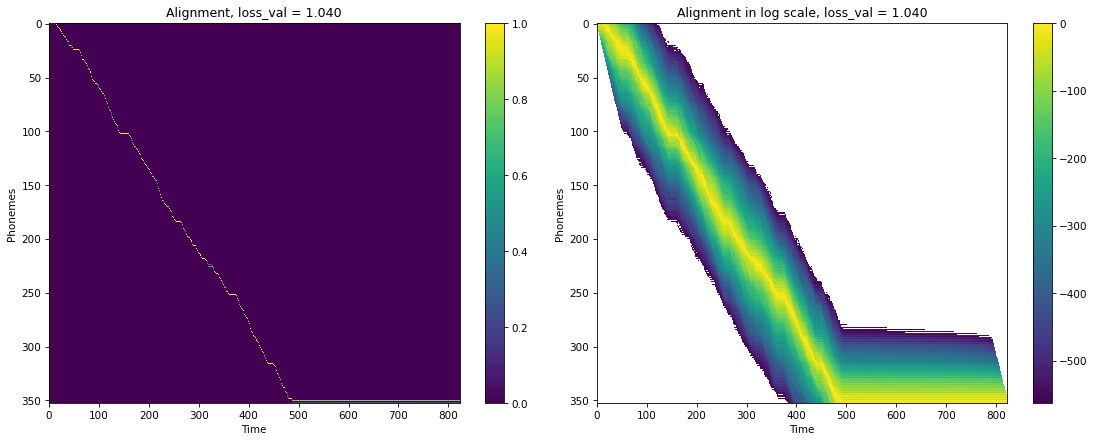

Epoch 13


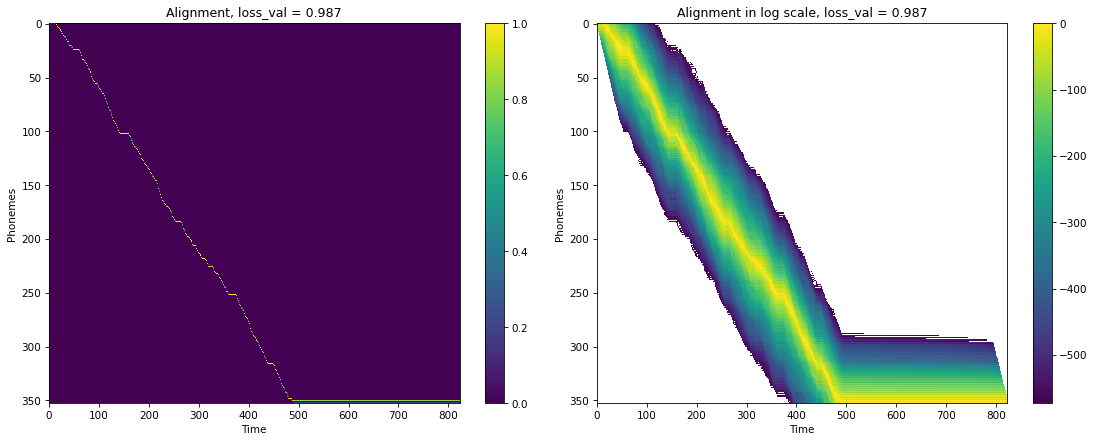

Epoch 16


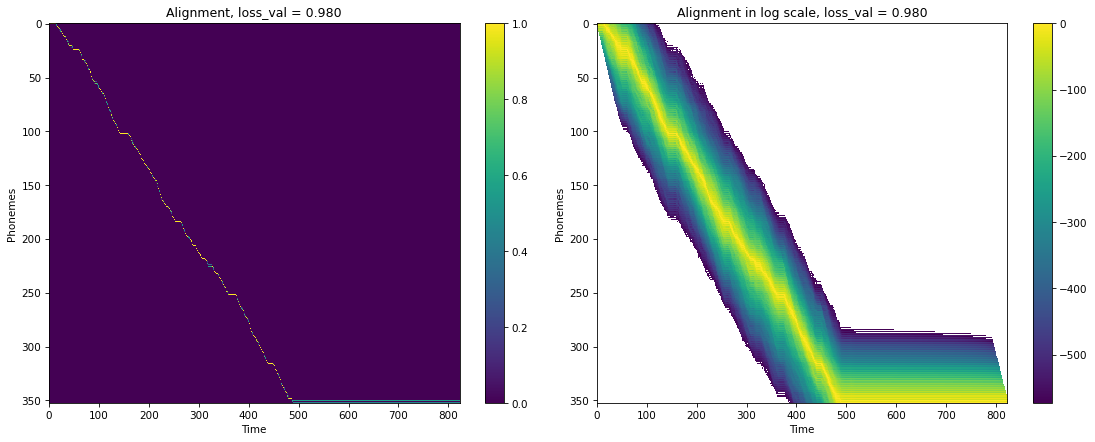

Model: ctc_rnn
Epoch 1


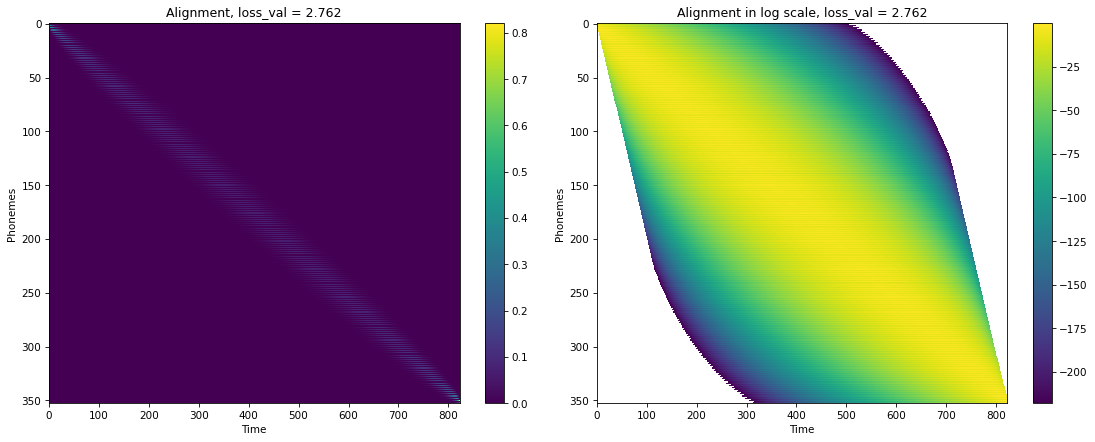

Epoch 4


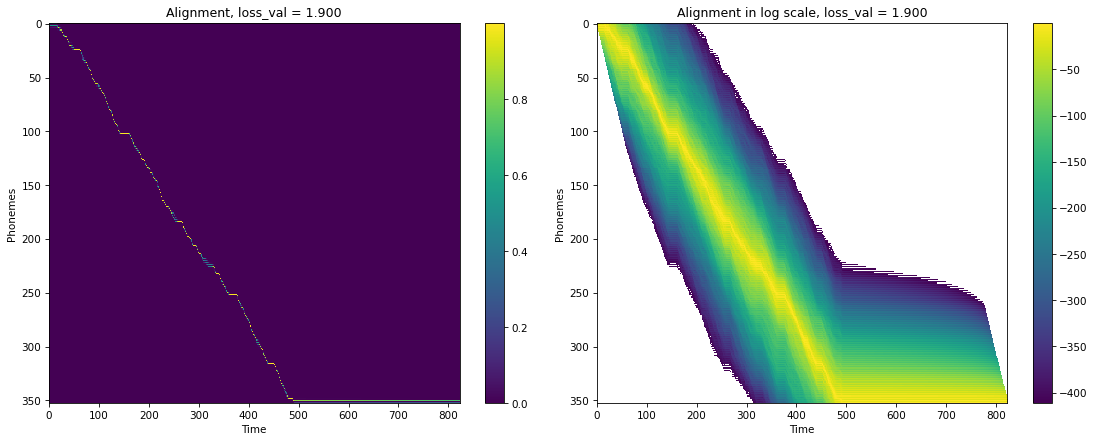

Epoch 7


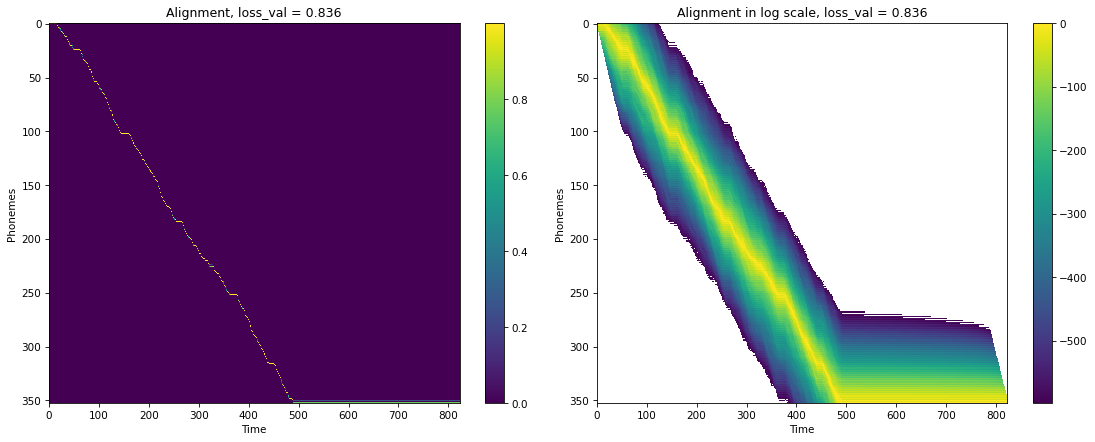

Epoch 10


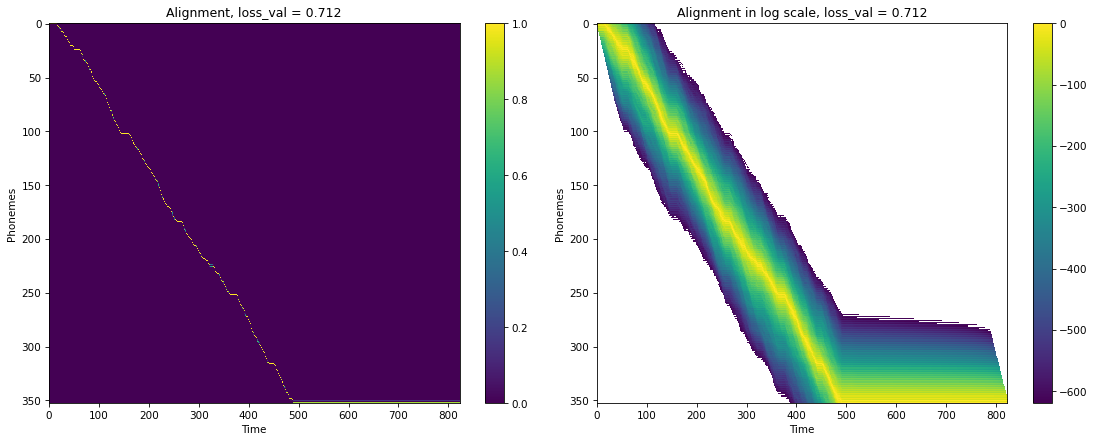

Epoch 13


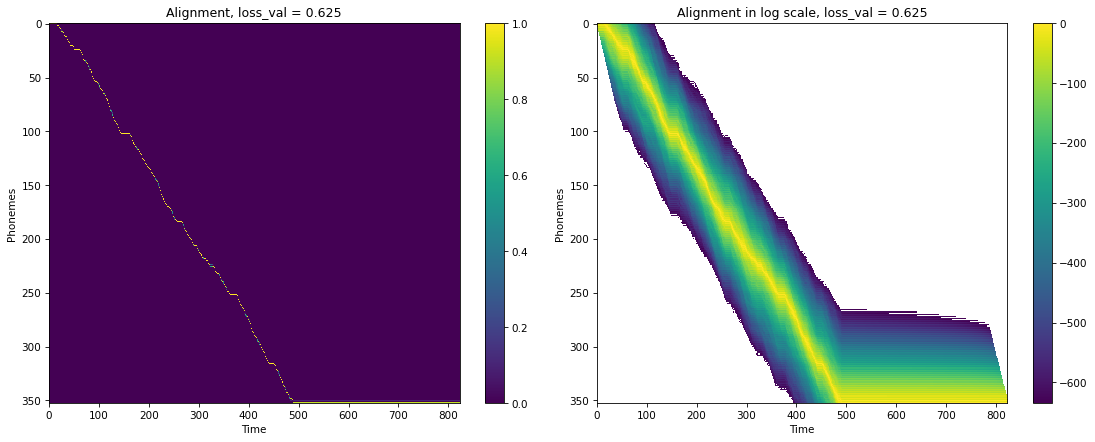

Epoch 16


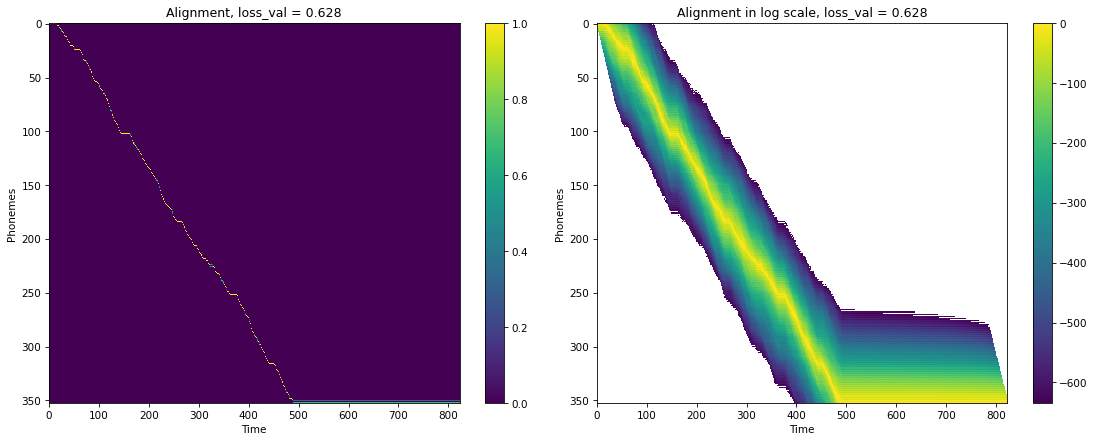

Model: ctc_birnn
Epoch 1


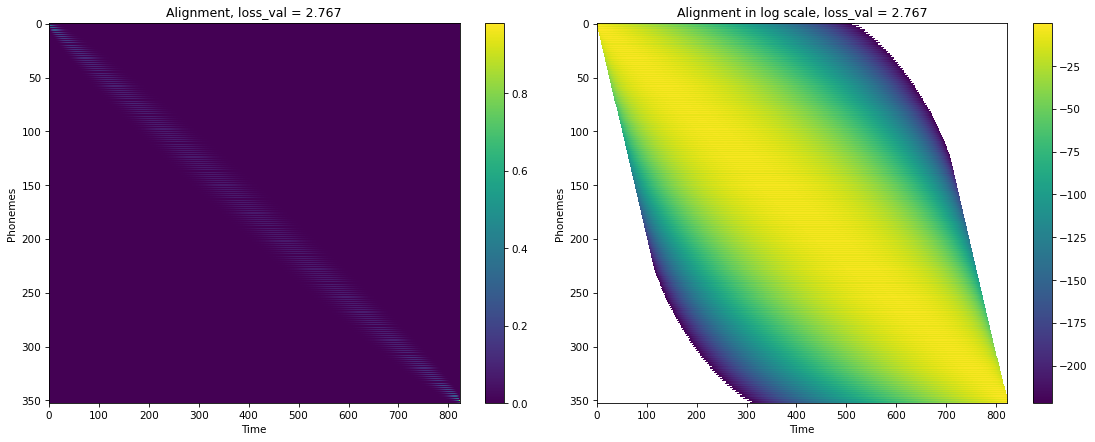

Epoch 4


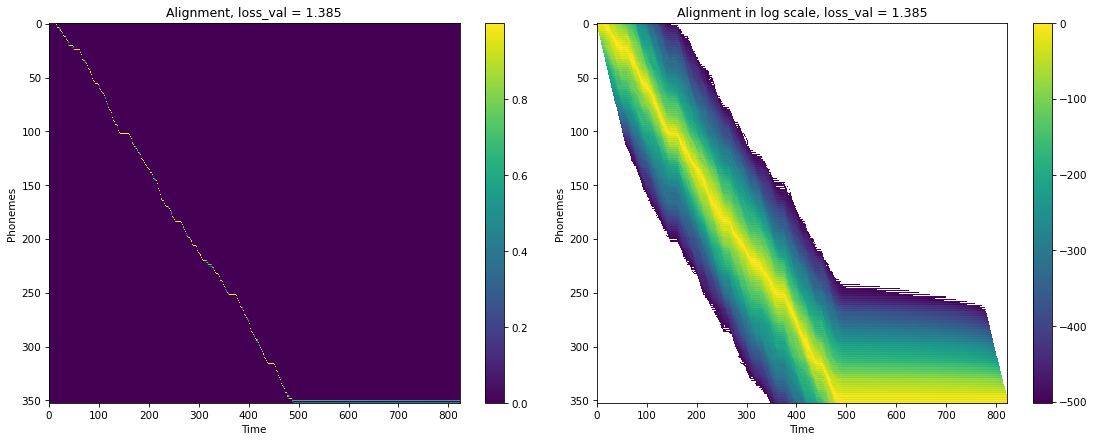

Epoch 7


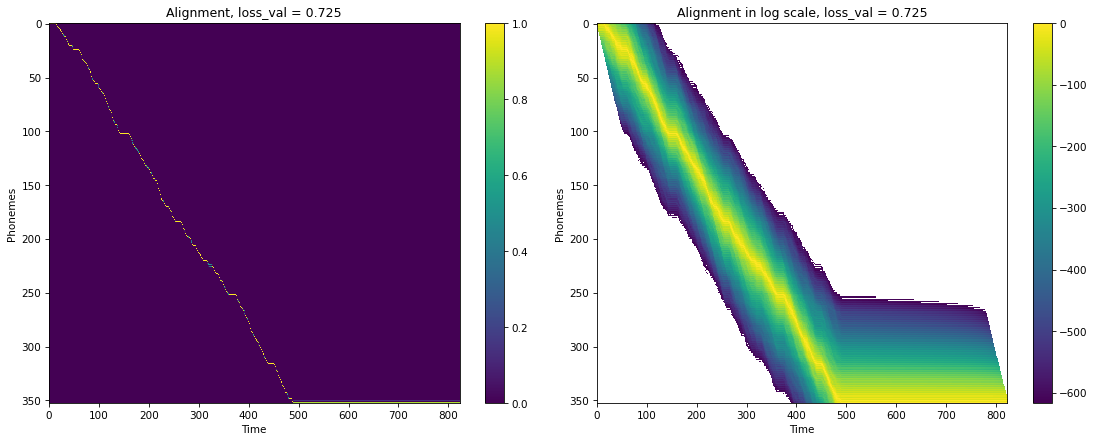

Epoch 10


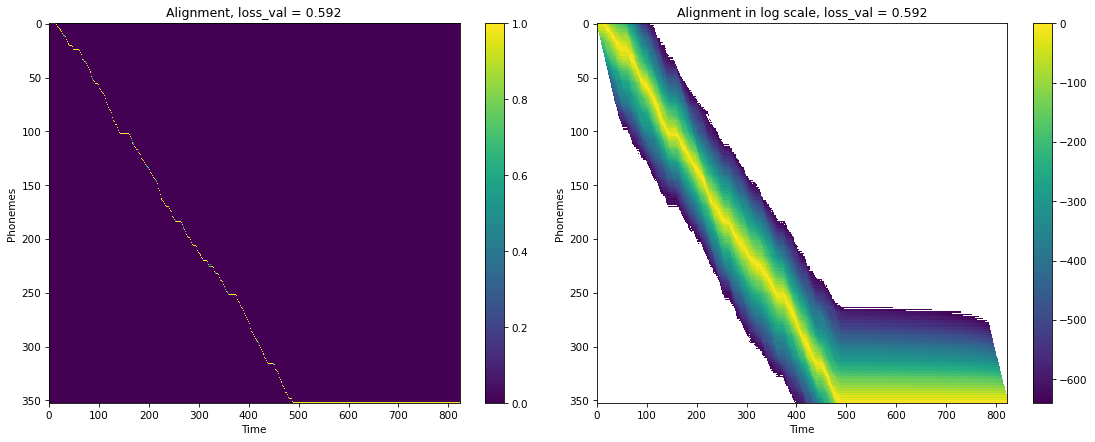

Epoch 13


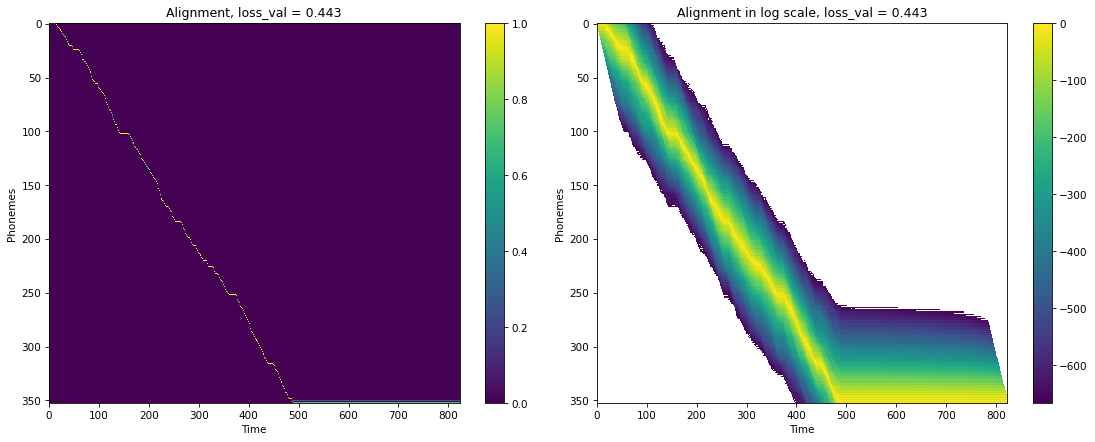

Epoch 16


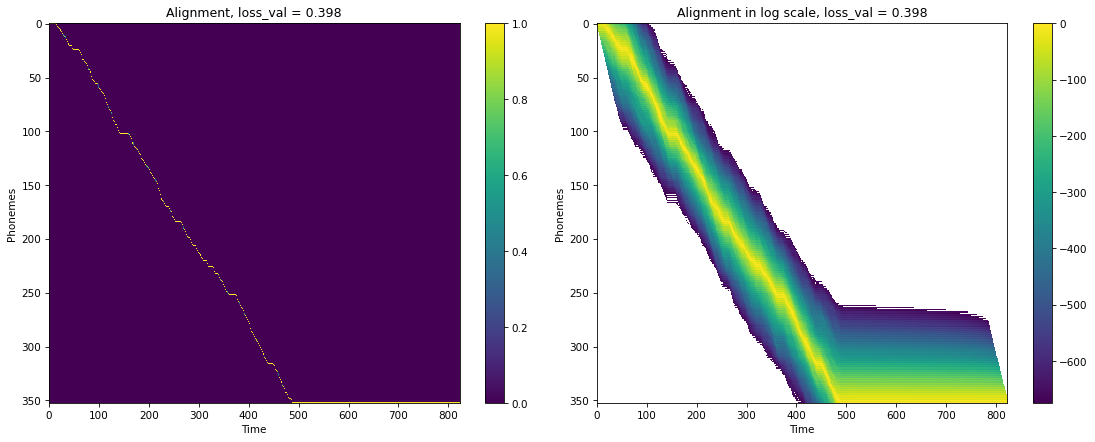

In [18]:
model_names = ('ctc_dnn', 'ctc_rnn', 'ctc_birnn')
model_to_hparams = {
    model_names[0]: {
        "n_cnn_layers": 5,
        "n_rnn_layers": 2,
        "rnn_dim": 128,
        "n_class": 29,
        "n_feats": 128,
        "stride": 2,
        "dropout": 0.2,
        "batch_size":  64,
    },
    model_names[1]: {
        "n_cnn_layers": 5,
        "n_rnn_layers": 2,
        "rnn_dim": 128,
        "n_class": 29,
        "n_feats": 128,
        "stride": 2,
        "dropout": 0.2,
        "batch_size":  64,
    },
    model_names[2]: {
        "n_cnn_layers": 4,
        "n_rnn_layers": 2,
        "rnn_dim": 128,
        "n_class": 29,
        "n_feats": 128,
        "stride": 2,
        "dropout": 0.2,
        "batch_size":  64,
    }
}
model_name_to_class = dict(zip(model_names, [CTCDNN, CTCRNN, CTCBiRNN]))

for model_nm in model_names:
    model_hparams = model_to_hparams[model_nm]
    model = model_name_to_class[model_nm](
        model_hparams['n_cnn_layers'],
        model_hparams['n_rnn_layers'],
        model_hparams['rnn_dim'],
        model_hparams['n_class'],
        model_hparams['n_feats'],
        model_hparams['stride'],
        model_hparams['dropout']
    ).to(device)
    
    print("Model:", model_nm)

    for epoch in np.arange(1, 18, 3):
        full_model_name = f"{model_nm}_epoch{epoch}.tar"
        utils.load_checkpoint(model, '', full_model_name, device)
        
        print(f"Epoch {epoch}")
        
        prob_matrix, labels, loss_val = calc_prob_matrix_and_loss(model, test_loader, device, batch_id=3, sample_id=2)
        plot_single_alignment(prob_matrix.T, labels, loss_val)
        plt.show()

С ростом качества модели, распределение вероятностей матрицы алайнментов становится более детерминированным, т.е. его энтропия уменьшается

### Alignment distribution over the dataset

Model = CTCBiRNN after 50 epochs

In [46]:
MODEL_NM = 'ctc_birnn'
model_hparams = model_to_hparams[MODEL_NM]
model = model_name_to_class[MODEL_NM](
    model_hparams['n_cnn_layers'],
    model_hparams['n_rnn_layers'],
    model_hparams['rnn_dim'],
    model_hparams['n_class'],
    model_hparams['n_feats'],
    model_hparams['stride'],
    model_hparams['dropout']
).to(device)

full_model_name = f"{MODEL_NM}_epoch50.tar"
utils.load_checkpoint(model, '', full_model_name, device)

/tmp/ipykernel_5475/3920012469.py:63: RuntimeWarning: divide by zero encountered in log
  im = ax[1].imshow(np.log(align), aspect='auto', interpolation='nearest')


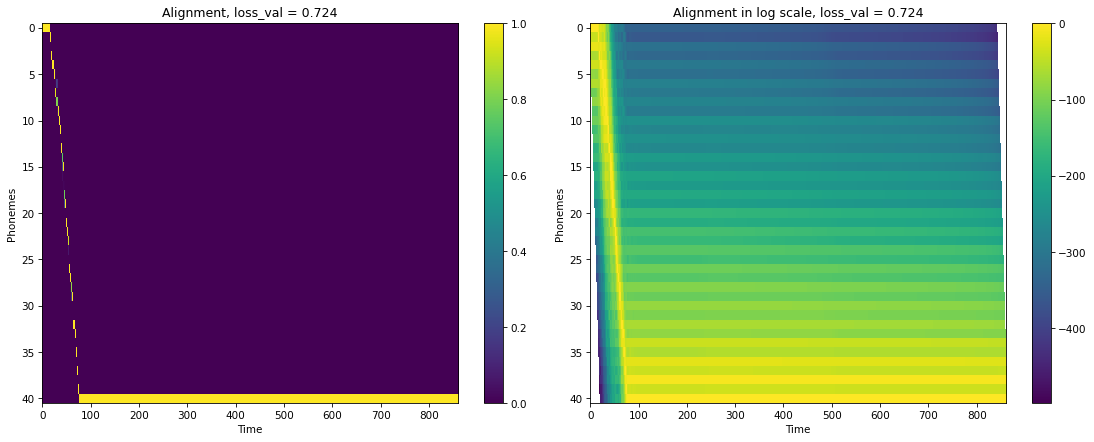

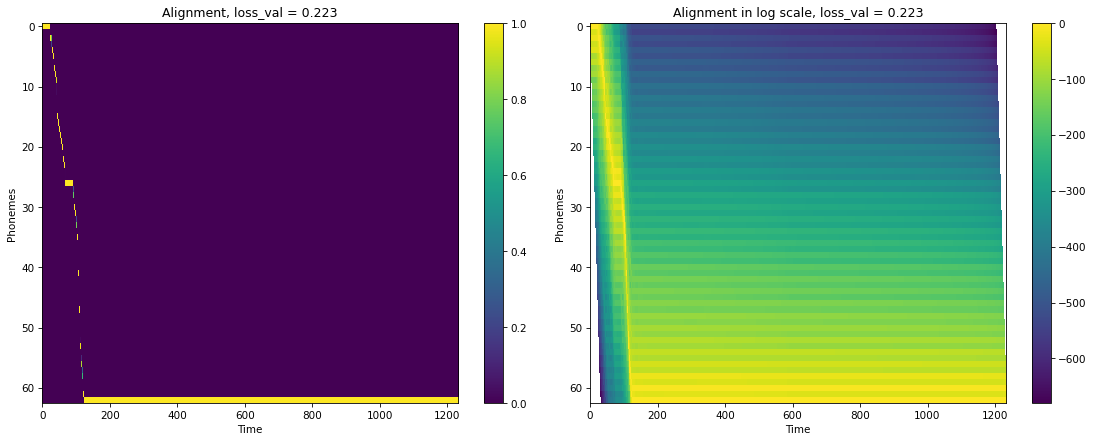

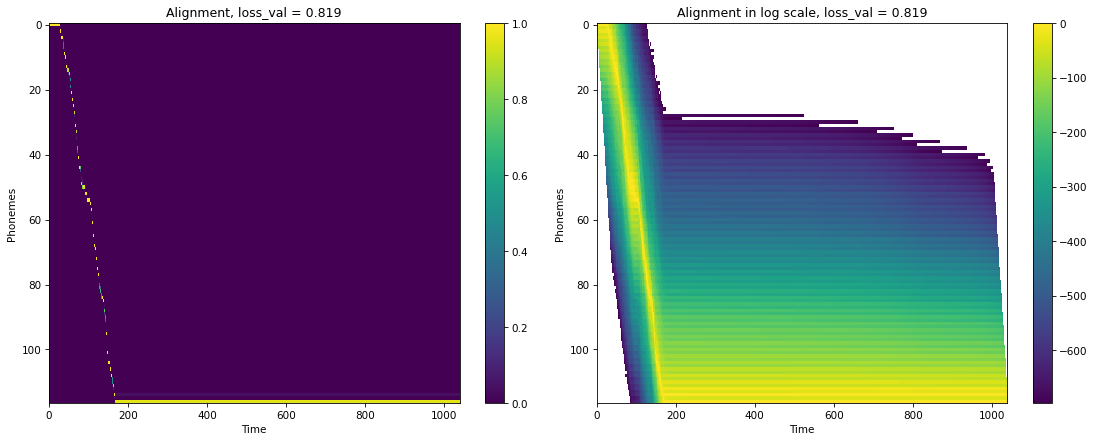

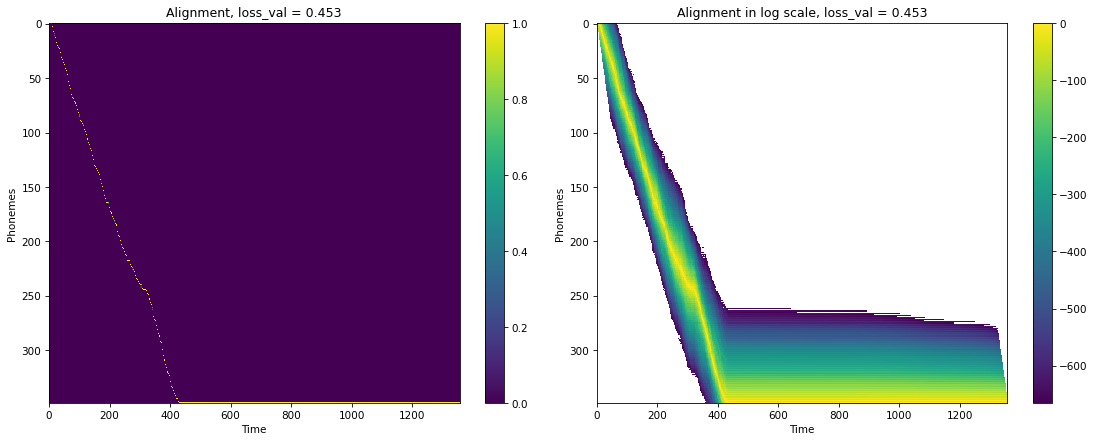

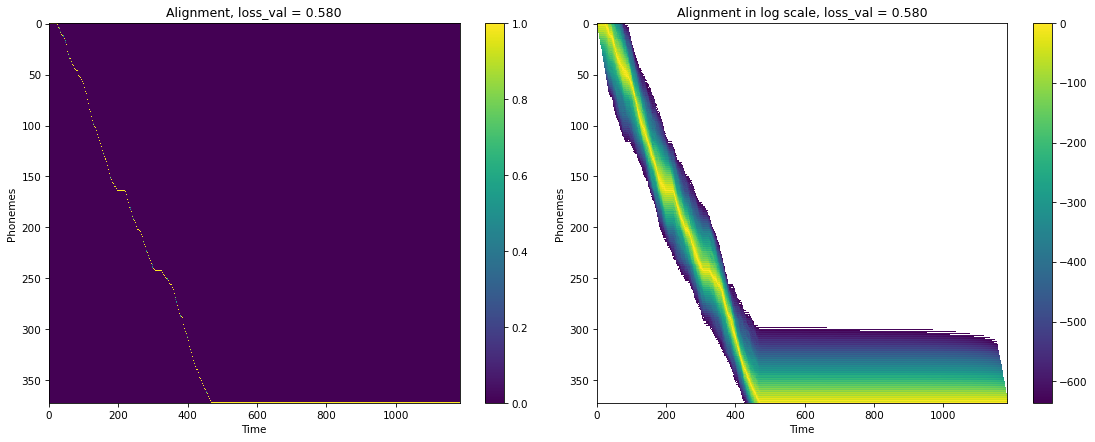

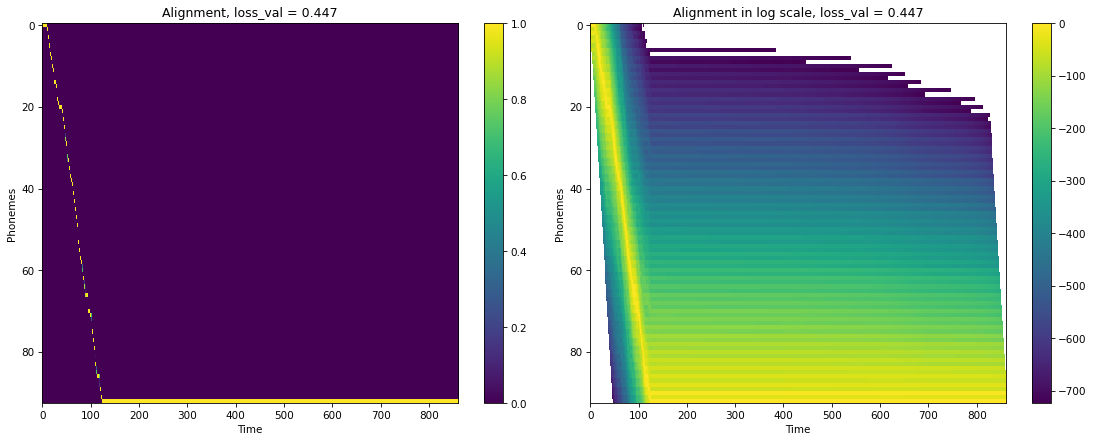

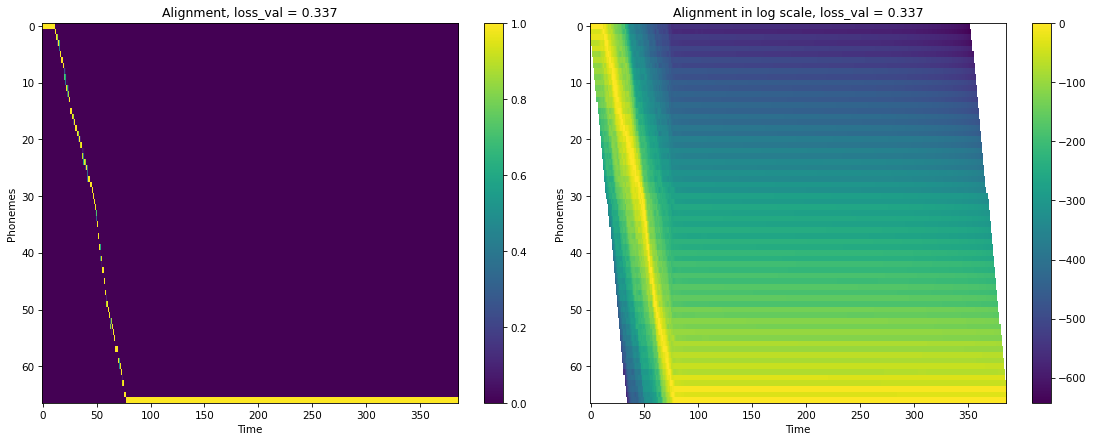

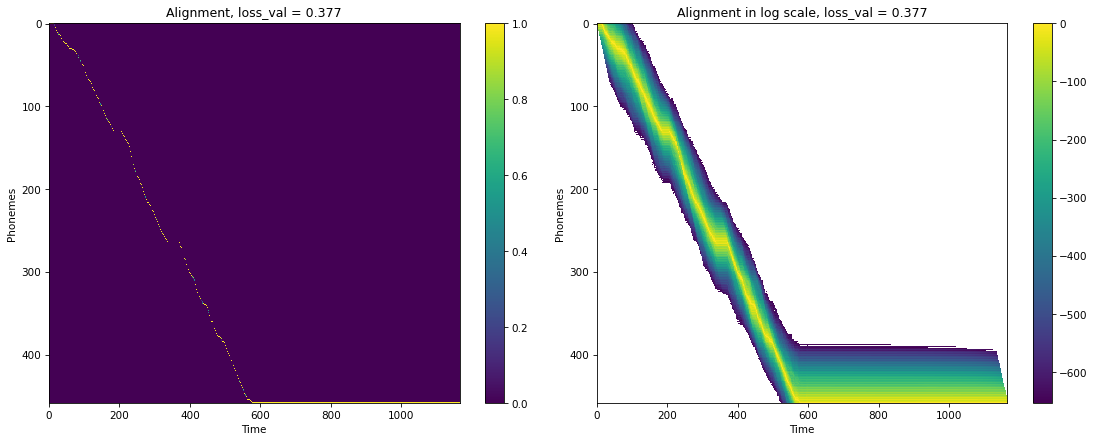

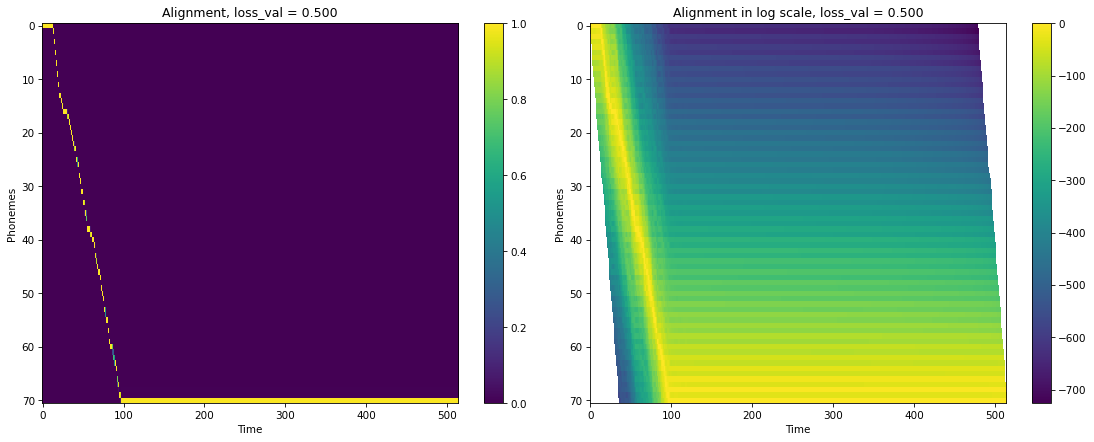

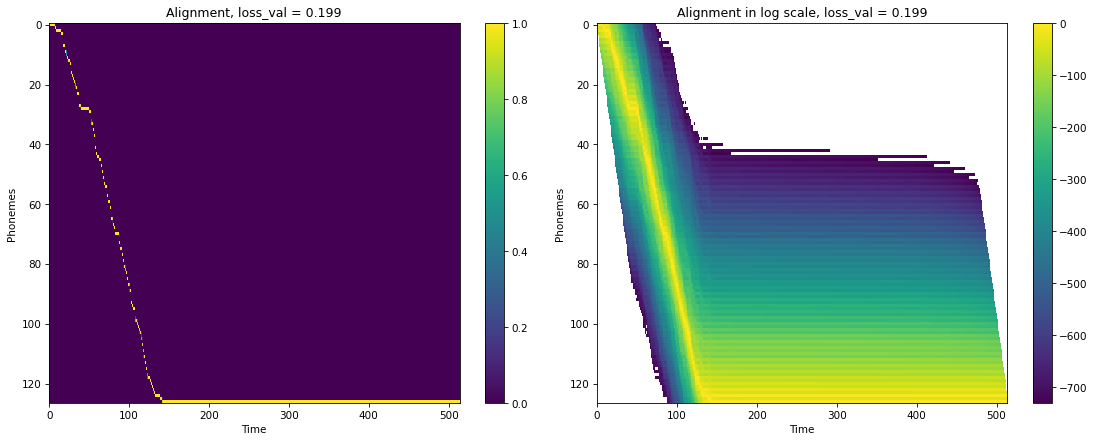

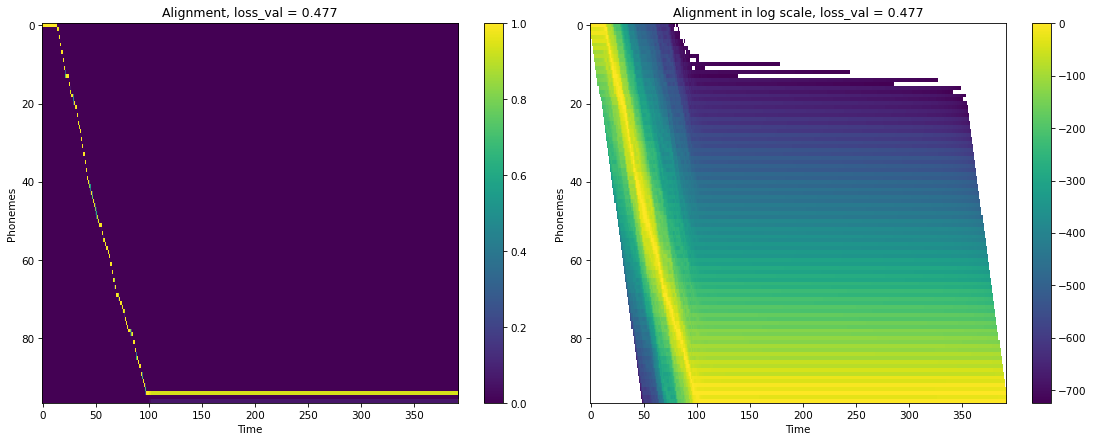

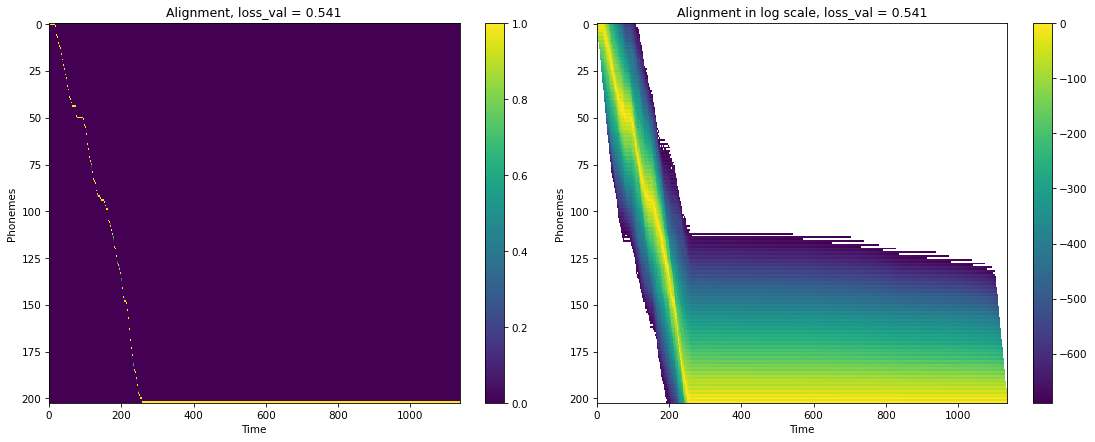

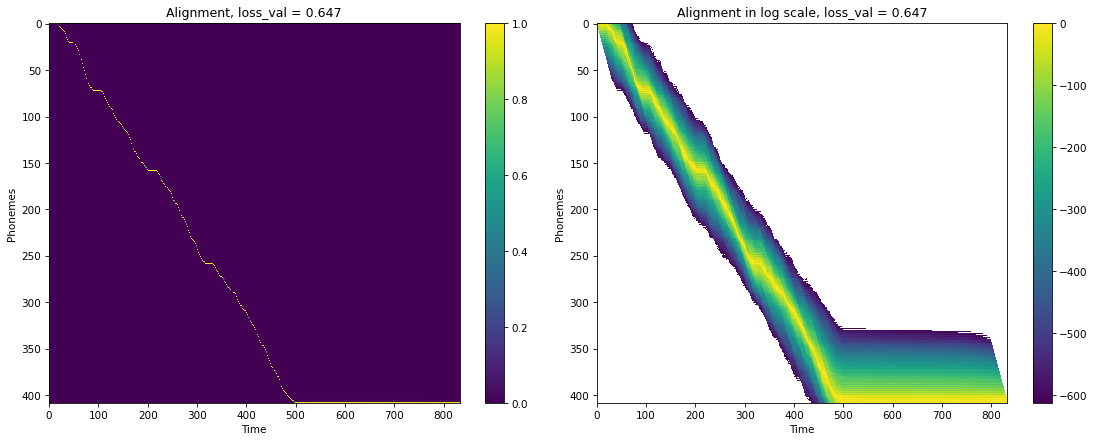

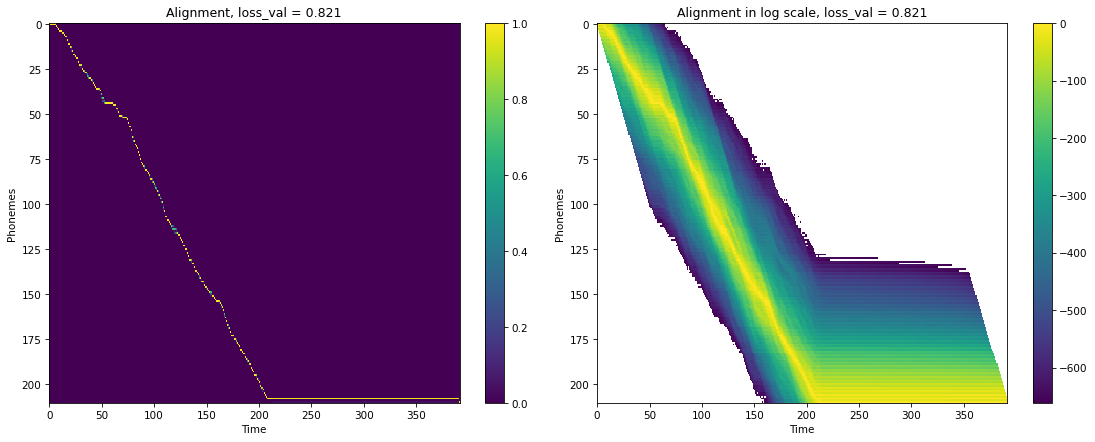

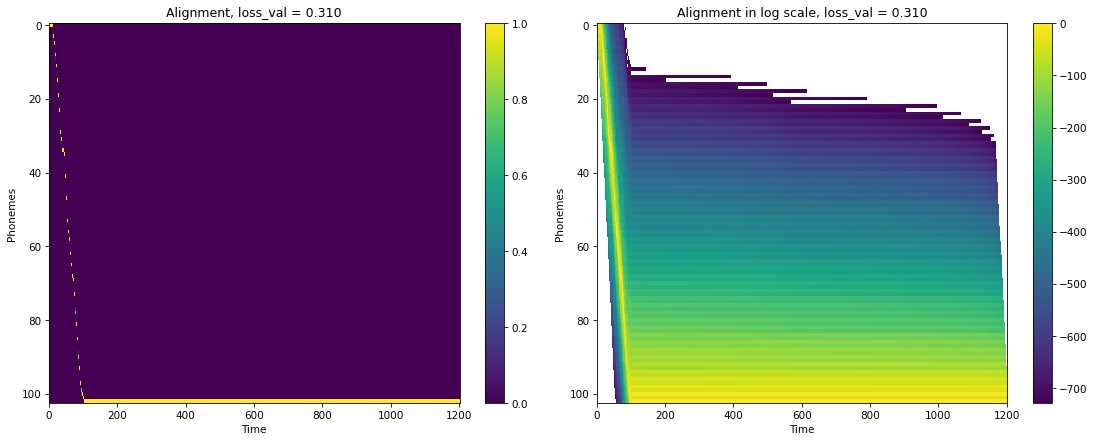

In [50]:
np.random.seed(42)

N_SAMPLES = 15

batch_ids = np.random.randint(0, len(test_loader), N_SAMPLES)
sample_ids = np.random.randint(0, 64, N_SAMPLES)

for batch_id, sample_id in zip(batch_ids, sample_ids):
    prob_matrix, labels, loss_val = calc_prob_matrix_and_loss(
        model,
        test_loader,
        device,
        batch_id=batch_id,
        sample_id=sample_id
    )
    plot_single_alignment(prob_matrix.T, labels, loss_val)
    plt.show()

Временная частота аудио почти для всех объектов в 2 раза больше необходимой (исключение -- последний объект). На графике это видно по нижней горизонтальной линии. Судя по вырваниваниям, в среднем достаточно временной частоты, равной 120% от кол-ва символов в целевом предложении (с учётом пустых символов).

Можно уменьшить кол-во временных бинов аудио вдвое, увеличив `stride` с 2 до 4. Таким образом, мы сильно уменьшим объём видеопамяти, используемой в процессе обучения, но при этом просядем в качестве. Это сделано ниже для трансформенной архитектуры.

Также можно заметить, что график логарифма матрицы вер-тей для коротких предложений имеет малое кол-во белых пятен. Белые пятна возникают, если у соответствующей области в каждой ячейке стоит 0, тогда log 0 = -inf, а -inf не отображается. Предположительно, это связано с тем, что у коротких предложений может быть больше вырваниваний, чем у длинных, так как количество прочтений пустых/одинаковых символов больше.

### Blank analysis

Судя по графикам выше, все модели используют примерно одинаковое количество символов-пропусков

## Modifications

### Add more augmentations + additional CTC-BiRNN training on 50 epochs

In [17]:
class AddNoise(nn.Module):
    def __init__(self, noise_factor=0.005):
        super(AddNoise, self).__init__()
        self.noise_factor = noise_factor

    def forward(self, audio):
        """
        audio: Tensor of shape (batch_size, channels, samples)
        """
        noise = torch.randn_like(audio)
        return audio + self.noise_factor * noise


class RandomAddNoise(nn.Module):
    def __init__(self, min_noise_factor=0.001, max_noise_factor=0.005):
        super(RandomAddNoise, self).__init__()
        self.min_noise_factor = min_noise_factor
        self.max_noise_factor = max_noise_factor

    def forward(self, audio):
        noise_factor = torch.empty(1).uniform_(self.min_noise_factor, self.max_noise_factor).item()
        noise = torch.randn_like(audio)
        return audio + noise_factor * noise
        

class ChangeVolume(nn.Module):
    def __init__(self, gain=1.0):
        super(ChangeVolume, self).__init__()
        self.gain = gain

    def forward(self, audio):
        return audio * self.gain
        
        
class RandomChangeVolume(nn.Module):
    def __init__(self, min_gain=0.8, max_gain=1.2):
        super(RandomChangeVolume, self).__init__()
        self.min_gain = min_gain
        self.max_gain = max_gain

    def forward(self, audio):
        gain = torch.empty(1).uniform_(self.min_gain, self.max_gain).item()
        return audio * gain     


class RandomApply(nn.Module):
    def __init__(self, transform, p=0.5):
        super(RandomApply, self).__init__()
        self.transform = transform
        self.p = p

    def forward(self, audio):
        if torch.rand(1).item() < self.p:
            return self.transform(audio)
        else:
            return audio

In [18]:
sample_rate = 16000

train_audio_transforms = nn.Sequential(
    RandomApply(RandomAddNoise(min_noise_factor=0.001, max_noise_factor=0.005), p=0.5),
    RandomApply(RandomChangeVolume(min_gain=0.8, max_gain=1.2), p=0.5),
    
    tt.MelSpectrogram(),
    tt.TimeMasking(time_mask_param=15),
    tt.FrequencyMasking(freq_mask_param=20)
)

test_audio_transforms = nn.Sequential(
    tt.MelSpectrogram()
)

/home/eduard/mambaforge/envs/mix/lib/python3.9/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [19]:
hparams = {
    "n_cnn_layers": 4,
    "n_rnn_layers": 2,
    "rnn_dim": 128,
    "n_class": 29,
    "n_feats": 128,
    "stride": 2,
    "dropout": 0.2,
    "learning_rate": 5e-4,
    "batch_size":  64,
    "epochs": 50,
}


train_collate_fn = Collate(data_type='train')
test_collate_fn = Collate(data_type='test')

# Define Dataloyour training and test data loaders
kwargs = {'num_workers': 2, 'pin_memory': True} if device == 'cuda' else {}
train_loader = data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True, collate_fn=train_collate_fn, **kwargs)

kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}
test_loader = data.DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False, collate_fn=test_collate_fn, **kwargs)

In [20]:
torch.manual_seed(42)

K_PREV_EPOCHS = 50

ctc_birnn = CTCBiRNN(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
).to(device)
utils.load_checkpoint(ctc_birnn, '', 'ctc_birnn.tar', device)

optimizer = optim.Adam(ctc_birnn.parameters(), hparams['learning_rate'])
optimizer.load_state_dict(torch.load('adam-birnn.pth'))

for g in optimizer.param_groups:
    g['lr'] = hparams['learning_rate']
    del g['initial_lr'], g['min_lr'], g['max_lr']

criterion = nn.CTCLoss(blank=tokenizer.get_symbol_index(BLANK_SYMBOL), reduction='mean')
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=hparams['learning_rate'],
    epochs=hparams['epochs'],
    steps_per_epoch=len(train_loader),
    div_factor=10,
    final_div_factor=3,
)

for epoch in tqdm(range(1, hparams['epochs'] + 1)):
    epoch += K_PREV_EPOCHS
    train(ctc_birnn, device, train_loader, criterion, optimizer, scheduler, epoch)
    utils.save_checkpoint(ctc_birnn, checkpoint_name=f'ctc_birnn_epoch{epoch}.tar')
    wandb.save(f'ctc_birnn_epoch{epoch}.tar')
    test(ctc_birnn, device, test_loader, criterion, epoch, save_path='birnn')

utils.save_checkpoint(ctc_birnn, checkpoint_name=f'ctc_birnn_v2.tar')

  0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch: 51 [0/28539 (0%)]	Loss: 0.701176
Train Epoch: 51 [6400/28539 (22%)]	Loss: 0.526274
Train Epoch: 51 [12800/28539 (45%)]	Loss: 0.509530
Train Epoch: 51 [19200/28539 (67%)]	Loss: 0.543731
Train Epoch: 51 [25600/28539 (90%)]	Loss: 0.584076
Beginning eval...
Epoch: 51, Test set: Average loss: 0.4919, Average CER: 0.144639 Average WER: 0.4164

Train Epoch: 52 [0/28539 (0%)]	Loss: 0.490991
Train Epoch: 52 [6400/28539 (22%)]	Loss: 0.543501
Train Epoch: 52 [12800/28539 (45%)]	Loss: 0.593798
Train Epoch: 52 [19200/28539 (67%)]	Loss: 0.486371
Train Epoch: 52 [25600/28539 (90%)]	Loss: 0.565359
Beginning eval...
Epoch: 52, Test set: Average loss: 0.4922, Average CER: 0.144746 Average WER: 0.4159

Train Epoch: 53 [0/28539 (0%)]	Loss: 0.524161
Train Epoch: 53 [6400/28539 (22%)]	Loss: 0.602670
Train Epoch: 53 [12800/28539 (45%)]	Loss: 0.490110
Train Epoch: 53 [19200/28539 (67%)]	Loss: 0.569086
Train Epoch: 53 [25600/28539 (90%)]	Loss: 0.543578
Beginning eval...
Epoch: 53, Test set: Averag

Train Epoch: 74 [12800/28539 (45%)]	Loss: 0.553396
Train Epoch: 74 [19200/28539 (67%)]	Loss: 0.506817
Train Epoch: 74 [25600/28539 (90%)]	Loss: 0.530303
Beginning eval...
Epoch: 74, Test set: Average loss: 0.4884, Average CER: 0.141915 Average WER: 0.4069

Train Epoch: 75 [0/28539 (0%)]	Loss: 0.535482
Train Epoch: 75 [6400/28539 (22%)]	Loss: 0.526970
Train Epoch: 75 [12800/28539 (45%)]	Loss: 0.497100
Train Epoch: 75 [19200/28539 (67%)]	Loss: 0.531653
Train Epoch: 75 [25600/28539 (90%)]	Loss: 0.533300
Beginning eval...
Epoch: 75, Test set: Average loss: 0.4863, Average CER: 0.142399 Average WER: 0.4090

Train Epoch: 76 [0/28539 (0%)]	Loss: 0.514123
Train Epoch: 76 [6400/28539 (22%)]	Loss: 0.470633
Train Epoch: 76 [12800/28539 (45%)]	Loss: 0.494861
Train Epoch: 76 [19200/28539 (67%)]	Loss: 0.543746
Train Epoch: 76 [25600/28539 (90%)]	Loss: 0.553325
Beginning eval...
Epoch: 76, Test set: Average loss: 0.4913, Average CER: 0.141848 Average WER: 0.4059

Train Epoch: 77 [0/28539 (0%)]	Loss: 

wandb: Network error (ReadTimeout), entering retry loop.


Train Epoch: 94 [6400/28539 (22%)]	Loss: 0.463004
Train Epoch: 94 [12800/28539 (45%)]	Loss: 0.492183
Train Epoch: 94 [19200/28539 (67%)]	Loss: 0.457197
Train Epoch: 94 [25600/28539 (90%)]	Loss: 0.446440
Beginning eval...
Epoch: 94, Test set: Average loss: 0.4533, Average CER: 0.131378 Average WER: 0.3825

Train Epoch: 95 [0/28539 (0%)]	Loss: 0.434634
Train Epoch: 95 [6400/28539 (22%)]	Loss: 0.472979
Train Epoch: 95 [12800/28539 (45%)]	Loss: 0.474340
Train Epoch: 95 [19200/28539 (67%)]	Loss: 0.405431
Train Epoch: 95 [25600/28539 (90%)]	Loss: 0.509400
Beginning eval...
Epoch: 95, Test set: Average loss: 0.4520, Average CER: 0.131338 Average WER: 0.3807

Train Epoch: 96 [0/28539 (0%)]	Loss: 0.474358
Train Epoch: 96 [6400/28539 (22%)]	Loss: 0.473244
Train Epoch: 96 [12800/28539 (45%)]	Loss: 0.468386
Train Epoch: 96 [19200/28539 (67%)]	Loss: 0.411337
Train Epoch: 96 [25600/28539 (90%)]	Loss: 0.479415
Beginning eval...
Epoch: 96, Test set: Average loss: 0.4524, Average CER: 0.131063 Average 

**Best quality**

In [53]:
hparams = {
    "n_cnn_layers": 4,
    "n_rnn_layers": 2,
    "rnn_dim": 128,
    "n_class": 29,
    "n_feats": 128,
    "stride": 2,
    "dropout": 0.2,
    "learning_rate": 5e-4,
    "batch_size":  64,
    "epochs": 50,
}

ctc_birnn = CTCBiRNN(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
).to(device)
print(sum(p.numel() for p in ctc_birnn.parameters() if p.requires_grad))
utils.load_checkpoint(ctc_birnn, '', 'ctc_birnn_v2.tar', device)
criterion = nn.CTCLoss(blank=tokenizer.get_symbol_index(BLANK_SYMBOL), reduction='mean')

test(ctc_birnn, device, test_loader, criterion, 0, save_path='none', decode='BeamSearch')

1345373
Beginning eval...
Epoch: 0, Test set: Average loss: 0.4504, Average CER: 0.127691 Average WER: 0.3714



### Try transformer-based architecture

In [299]:
class AdaptiveMinPool2d(nn.Module):
    def __init__(self, output_size):
        super(AdaptiveMinPool2d, self).__init__()
        self.max_pool = nn.AdaptiveMaxPool2d(output_size)
    
    def forward(self, x):
        return -self.max_pool(-x)
    

class CTCTransformer(nn.Module):
    def __init__(self, n_cnn_layers: int, num_heads: int, hidden_dim: int, n_class: int, 
                 n_feats: int, stride: int = 2, dropout: float = 0.1) -> None:
        super(CTCTransformer, self).__init__()
        
        self.feature_extractor = FeatureExtractor(
            n_cnn_layers,
            hidden_dim,
            n_feats,
            stride,
            dropout
        )

        self.intermediate_layers = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, n_class)
        )

    def forward(self, x: torch.Tensor, input_lengths: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        batch_size, time_steps, n_features = x.shape

        mask = nn.Transformer.generate_square_subsequent_mask(time_steps).to(x.device)
        attn_output, _ = self.intermediate_layers(x, x, x, is_causal=True, attn_mask=mask, need_weights=False)
        
        x = self.classifier(attn_output)
        return x

In [300]:
hparams = {
    "n_cnn_layers": 6,
    "num_heads": 4,
    "hidden_dim": 256,
    "n_class": 29,
    "n_feats": 128,
    "stride": 4,
    "dropout": 0.2,
    "learning_rate": 1e-3,
    "batch_size":  64,
    "epochs": 50,
}

train_collate_fn = Collate(data_type='train', stride=hparams['stride'])
test_collate_fn = Collate(data_type='test', stride=hparams['stride'])

# Define Dataloyour training and test data loaders
kwargs = {'num_workers': 2, 'pin_memory': True} if device == 'cuda' else {}
train_loader = data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True, collate_fn=train_collate_fn, **kwargs)

kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}
test_loader = data.DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False, collate_fn=test_collate_fn, **kwargs)

In [20]:
wandb.init(
    project="hw2-dlaudio", 
    group="Transformer",
    config=hparams,
    reinit=True
)

wandb: Currently logged in as: edyarich (edyarich-noname). Use `wandb login --relogin` to force relogin


In [301]:
torch.manual_seed(42)

ctc_transformer = CTCTransformer(
    hparams['n_cnn_layers'], hparams['num_heads'], hparams['hidden_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
).to(device)

print(sum(p.numel() for p in ctc_transformer.parameters() if p.requires_grad))

optimizer = optim.Adam(ctc_transformer.parameters(), hparams['learning_rate'])
criterion = nn.CTCLoss(blank=tokenizer.get_symbol_index(BLANK_SYMBOL), reduction='mean', zero_infinity=True)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=hparams['learning_rate'],
    epochs=hparams['epochs'],
    steps_per_epoch=len(train_loader),
    div_factor=5,
    final_div_factor=10,
)

for epoch in tqdm(range(1, hparams['epochs'] + 1)):
    train(ctc_transformer, device, train_loader, criterion, optimizer, scheduler, epoch)
    utils.save_checkpoint(ctc_transformer, checkpoint_name=f'ctc_transformer_epoch{epoch}.tar')
    wandb.save(f'ctc_transformer_epoch{epoch}.tar')
    test(ctc_transformer, device, test_loader, criterion, epoch, save_path='transformer')

utils.save_checkpoint(ctc_transformer, checkpoint_name=f'ctc_transformer.tar')

623581


  0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch: 1 [0/28539 (0%)]	Loss: 3.750787
Train Epoch: 1 [6400/28539 (22%)]	Loss: 2.855346
Train Epoch: 1 [12800/28539 (45%)]	Loss: 2.784313
Train Epoch: 1 [19200/28539 (67%)]	Loss: 2.821913
Train Epoch: 1 [25600/28539 (90%)]	Loss: 2.819638
Beginning eval...
Epoch: 1, Test set: Average loss: 2.8740, Average CER: 1.000000 Average WER: 1.0050

Train Epoch: 2 [0/28539 (0%)]	Loss: 2.883327
Train Epoch: 2 [6400/28539 (22%)]	Loss: 2.806440
Train Epoch: 2 [12800/28539 (45%)]	Loss: 2.853818
Train Epoch: 2 [19200/28539 (67%)]	Loss: 2.759905
Train Epoch: 2 [25600/28539 (90%)]	Loss: 2.802166
Beginning eval...
Epoch: 2, Test set: Average loss: 2.7759, Average CER: 0.697507 Average WER: 1.2187

Train Epoch: 3 [0/28539 (0%)]	Loss: 2.693079
Train Epoch: 3 [6400/28539 (22%)]	Loss: 2.705988
Train Epoch: 3 [12800/28539 (45%)]	Loss: 2.712581
Train Epoch: 3 [19200/28539 (67%)]	Loss: 2.691166
Train Epoch: 3 [25600/28539 (90%)]	Loss: 2.661331
Beginning eval...
Epoch: 3, Test set: Average loss: 2.6323, Av

wandb: Network error (ConnectionError), entering retry loop.


Epoch: 5, Test set: Average loss: 2.4900, Average CER: 0.618866 Average WER: 1.0987

Train Epoch: 6 [0/28539 (0%)]	Loss: 2.549571
Train Epoch: 6 [6400/28539 (22%)]	Loss: 2.536687
Train Epoch: 6 [12800/28539 (45%)]	Loss: 2.535653
Train Epoch: 6 [19200/28539 (67%)]	Loss: 2.531254
Train Epoch: 6 [25600/28539 (90%)]	Loss: 2.493556
Beginning eval...
Epoch: 6, Test set: Average loss: 2.4479, Average CER: 0.597537 Average WER: 1.0995

Train Epoch: 7 [0/28539 (0%)]	Loss: 2.520330
Train Epoch: 7 [6400/28539 (22%)]	Loss: 2.525692
Train Epoch: 7 [12800/28539 (45%)]	Loss: 2.459913
Train Epoch: 7 [19200/28539 (67%)]	Loss: 2.468815
Train Epoch: 7 [25600/28539 (90%)]	Loss: 2.426950
Beginning eval...
Epoch: 7, Test set: Average loss: 2.4042, Average CER: 0.581704 Average WER: 1.0860

Train Epoch: 8 [0/28539 (0%)]	Loss: 2.522234
Train Epoch: 8 [6400/28539 (22%)]	Loss: 2.484989
Train Epoch: 8 [12800/28539 (45%)]	Loss: 2.443666
Train Epoch: 8 [19200/28539 (67%)]	Loss: 2.460174
Train Epoch: 8 [25600/28539

wandb: Network error (TransientError), entering retry loop.


Epoch: 9, Test set: Average loss: 2.3474, Average CER: 0.558458 Average WER: 1.0365

Train Epoch: 10 [0/28539 (0%)]	Loss: 2.443982
Train Epoch: 10 [6400/28539 (22%)]	Loss: 2.417631
Train Epoch: 10 [12800/28539 (45%)]	Loss: 2.416427
Train Epoch: 10 [19200/28539 (67%)]	Loss: 2.417524
Train Epoch: 10 [25600/28539 (90%)]	Loss: 2.402544
Beginning eval...
Epoch: 10, Test set: Average loss: 2.2930, Average CER: 0.541292 Average WER: 1.0671

Train Epoch: 11 [0/28539 (0%)]	Loss: 2.390490
Train Epoch: 11 [6400/28539 (22%)]	Loss: 2.431379
Train Epoch: 11 [12800/28539 (45%)]	Loss: 2.359257
Train Epoch: 11 [19200/28539 (67%)]	Loss: 2.451380
Train Epoch: 11 [25600/28539 (90%)]	Loss: 2.496327
Beginning eval...
Epoch: 11, Test set: Average loss: 2.2814, Average CER: 0.538182 Average WER: 1.0649

Train Epoch: 12 [0/28539 (0%)]	Loss: 2.384151
Train Epoch: 12 [6400/28539 (22%)]	Loss: 2.358462
Train Epoch: 12 [12800/28539 (45%)]	Loss: 2.345178
Train Epoch: 12 [19200/28539 (67%)]	Loss: 2.383575
Train Epoch

Train Epoch: 33 [0/28539 (0%)]	Loss: 2.089042
Train Epoch: 33 [6400/28539 (22%)]	Loss: 2.141732
Train Epoch: 33 [12800/28539 (45%)]	Loss: 2.235480
Train Epoch: 33 [19200/28539 (67%)]	Loss: 2.143035
Train Epoch: 33 [25600/28539 (90%)]	Loss: 2.196334
Beginning eval...
Epoch: 33, Test set: Average loss: 1.9388, Average CER: 0.456375 Average WER: 0.9604

Train Epoch: 34 [0/28539 (0%)]	Loss: 2.163991
Train Epoch: 34 [6400/28539 (22%)]	Loss: 2.140014
Train Epoch: 34 [12800/28539 (45%)]	Loss: 2.167839
Train Epoch: 34 [19200/28539 (67%)]	Loss: 2.168449
Train Epoch: 34 [25600/28539 (90%)]	Loss: 2.218399
Beginning eval...
Epoch: 34, Test set: Average loss: 1.9346, Average CER: 0.452591 Average WER: 0.9525

Train Epoch: 35 [0/28539 (0%)]	Loss: 2.114009
Train Epoch: 35 [6400/28539 (22%)]	Loss: 2.168196
Train Epoch: 35 [12800/28539 (45%)]	Loss: 2.075338
Train Epoch: 35 [19200/28539 (67%)]	Loss: 2.094110
Train Epoch: 35 [25600/28539 (90%)]	Loss: 2.129345
Beginning eval...
Epoch: 35, Test set: Averag

**Вывод:**

Трансформеры не показали хорошего качества

## General conclusion

1. Лучший WER = 0.3714 на CTC_BiRNN, обученной за 100 эпох, с использованием BeamSearch с beam_size=5 для предсказания

2. Использование языковой модели ухудшает качество предсказания